# Analysing solutions

## Setup

In [1]:
import itertools
import os
import re
import string
import xml.etree.ElementTree as ET

import cobra
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from matplotlib.ticker import MultipleLocator
from mmon_gcm.analysing import get_escher_map
from mmon_gcm.supermodel import SuperModel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()
sns.set_style("ticks")
sns.set_palette(
    sns.color_palette(
        [
            "#332288",
            "#88CCEE",
            "#44AA99",
            "#117733",
            "#999933",
            "#DDCC77",
            "#CC6677",
            "#882255",
            "#AA4499",
        ]
    )
)
colours = sns.color_palette()

params = {
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "x-large",
    #"axes.labelweight": "bold",
    #"axes.titleweight": "bold",
    #"font.weight": "bold",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
}

#plt.rcParams['font.family'] = 'Arial'

plt.rcParams.update(params)

In [4]:
def get_multiphase_fluxes(df, reaction):
    reaction_phased = [f"{reaction}_{i+1}" for i in range(4)]
    selected_df = df.loc[reaction_phased, "fluxes"]
    return selected_df

In [5]:
def convert_phases_to_times(df, phase_times=[6, 6.5, 18, 24]):
    df.index = pd.MultiIndex.from_tuples([(row[0], phase_times[row[1] - 1]) for row in df.index], names=df.index.names)
    df = df.reorder_levels(["Phase", "Reaction"]).sort_index()
    df = df.append(pd.concat([df.loc[24]], keys=[0]))
    df = df.sort_index()
    df = df.reorder_levels(["Reaction", "Phase"]).sort_index()

    return df

In [6]:
def select_volume_based_on_id(reaction_id, SuperModel):
    total_gc_volume = SuperModel.get_volumes(per_guard_cell=False)

    if "total" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False)
    elif "v_gc" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False) * SuperModel.Vac_frac
    elif "c_gc" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False) * (1 - SuperModel.Vac_frac)
    elif "p_gc" in reaction_id:
        phase_volumes = [1] * 4
    else:
        raise ValueError(f"Don't know how to deal with {reaction_id}")

    return phase_volumes

In [7]:
def convert_to_conc(row, SuperModel, phases_in_df=[0, 6, 6.5, 18, 24]):
    phase = row.name[1]

    phase_conversion_dict = {
        phases_in_df[0]: 4,
        phases_in_df[1]: 1,
        phases_in_df[2]: 2,
        phases_in_df[3]: 3,
        phases_in_df[4]: 4,
    }

    phase_volumes = select_volume_based_on_id(row.name[0], SuperModel)

    volume_for_phase = phase_volumes[phase_conversion_dict[phase] - 1]

    return row / volume_for_phase

In [8]:
def get_metabolite_df(solutions_df, concentrations=True, total_mets=None, SuperModel=None):
    if total_mets == None:
        total_mets = ["SUCROSE", "GLC", "MAL", "FRU", "K", "Cl", "CIT"]
    total_mets_reactions = [met + "_total_pseudolinker" for met in total_mets] + ["STARCH_p_gc_Linker"]
    total_mets_reactions_phased = [f"{reaction}_{i+1}" for i in range(4) for reaction in total_mets_reactions]
    met_df = (solutions_df.loc[total_mets_reactions]).copy()

    # change index to phase times instead of tags
    met_df = convert_phases_to_times(met_df)

    if concentrations == True:
        met_df = met_df.apply(convert_to_conc, args=([SuperModel]), axis=1)

    met_df = met_df.reorder_levels(["Phase", "Reaction"]).sort_index()

    met_df.index = pd.MultiIndex.from_tuples(
        [(index[0], index[1].split("_")[0]) for index in met_df.index],
        names=met_df.index.names,
    )

    return met_df

In [9]:
def get_closed_open_values(met_df_mm, light, atpase):
    open_closed_dict = {}

    for genotype in ["wt", "starchko"]:
        open_closed_dict[genotype] = {}
        open_closed_dict[genotype]["closed"] = met_df_mm.loc[~(met_df_mm.index == (6, "STARCH"))].loc[
            6, (light, atpase, genotype, "fluxes")
        ]
        open_closed_dict[genotype]["open"] = met_df_mm.loc[~(met_df_mm.index == (6.5, "STARCH"))].loc[
            6.5, (light, atpase, genotype, "fluxes")
        ]

    return open_closed_dict

In [10]:
def get_closed_open_values(met_df_mm, light, atpase):
    open_closed_dict = {}

    for genotype in ["wt", "starchko"]:
        open_closed_dict[genotype] = {}
        open_closed_dict[genotype]["closed"] = met_df_mm.loc[6, (light, atpase, genotype, "fluxes")]
        open_closed_dict[genotype]["open"] = met_df_mm.loc[6.5, (light, atpase, genotype, "fluxes")]

    return open_closed_dict

In [11]:
def get_totals_plot(specific_met_df):
    colours = ["#999999ff", "#ff7043ff"]
    mpl.rcParams["hatch.linewidth"] = 1.5
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios": [7, 1]})

    closed_metabolite_df = specific_met_df.loc[6.0].drop("STARCH")
    open_metabolite_df = specific_met_df.loc[6.5].drop("STARCH")

    # plot wt
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 - 0.05,
        closed_metabolite_df["wt"],
        color=colours[0],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
    )
    axs[0].bar(
        np.array(range(len(open_metabolite_df))) * 2 + 0.05,
        open_metabolite_df["wt"],
        color=colours[1],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
    )

    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 - 0.05,
        closed_metabolite_df["starchko"],
        color=colours[0],
        width=-0.3,
        align="edge",
        edgecolor="white",
        hatch="//",
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 + 0.05,
        open_metabolite_df["starchko"],
        color=colours[1],
        width=0.3,
        align="edge",
        edgecolor="white",
        hatch="//",
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 - 0.05,
        closed_metabolite_df["starchko"],
        color="none",
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 + 0.05,
        open_metabolite_df["starchko"],
        color="none",
        width=0.3,
        align="edge",
        edgecolor=colours[1],
    )

    x_ticks_pad = 12
    axs[0].tick_params(axis="x", which="both", bottom=False, pad=x_ticks_pad)
    axs[1].tick_params(axis="x", which="both", bottom=False, pad=x_ticks_pad)

    starch_closed = specific_met_df.loc[(6.0, "STARCH")]
    starch_open = specific_met_df.loc[(6.5, "STARCH")]

    axs[1].bar(
        -0.05,
        starch_closed["wt"],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
        color=colours[0],
    )
    axs[1].bar(
        0.05,
        starch_open["wt"],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
        color=colours[1],
    )

    axs[1].bar(
        1 - 0.05,
        starch_closed["starchko"],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
        color=colours[0],
        hatch="//",
    )
    axs[1].bar(
        1 + 0.05,
        starch_open["starchko"],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
        color=colours[1],
        hatch="//",
    )

    main_x_tick_labels = [name[0] + name[1:3].lower() for name in open_metabolite_df.index]

    main_x_tick_labels_superscripted = []
    for label in main_x_tick_labels:
        if label == "K":
            new_label = r"K$^+$"
        elif label == "Cl":
            new_label = r"Cl$^-$"
        else:
            new_label = label
        main_x_tick_labels_superscripted.append(new_label)

    main_x_tick_labels = main_x_tick_labels_superscripted

    main_x_ticks = np.array(range(len(closed_metabolite_df))) * 2 + 0.5

    ax0_y_max = 60

    axs[0].set_xticks(main_x_ticks)
    axs[0].set_xticklabels(main_x_tick_labels)
    axs[0].set_ylim(-0.1, ax0_y_max)
    axs[0].set_xlim(-0.5, 13.5)
    axs[0].set_ylabel(r"Osmolyte concentration (mM)")
    axs[0].yaxis.set_major_locator(MultipleLocator(10))
    # axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))

    for x_loc in [(x - 1) * 2 + 1.5 for x in range(len(closed_metabolite_df))]:
        axs[0].hlines(-3.7, x_loc + 0.1, x_loc + 1.9, clip_on=False, color="black", alpha=0.9)
        for offset, label in zip([0.5, 1.5], ["WT", "KO"]):
            axs[0].text(x_loc + offset, -2, label, ha="center", va="center", size="small")

    starch_x_tick_labels = ["Starch"]
    starch_x_ticks = [0.5]

    ax1_y_max = 14

    axs[1].set_xticks(starch_x_ticks)
    axs[1].set_xticklabels(starch_x_tick_labels)
    axs[1].set_ylim(-0.1 * ax1_y_max / ax0_y_max, ax1_y_max)
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_major_locator(MultipleLocator(2))
    # axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[1].spines["right"].set_visible(True)
    axs[1].spines["left"].set_visible(False)
    axs[1].set_ylabel(r"Amount (fmol$\cdot$GC$^{-1}$)")

    for x_loc in [(x - 1) * 2 + 1.5 for x in [0]]:
        axs[1].hlines(
            -3.7 * ax1_y_max / ax0_y_max,
            x_loc + 0.1,
            x_loc + 2,
            clip_on=False,
            color="black",
            alpha=0.9,
        )
        for offset, label in zip([0.5, 1.5], ["WT", "KO"]):
            axs[1].text(
                x_loc + offset,
                -2 * ax1_y_max / ax0_y_max,
                label,
                ha="center",
                va="center",
                size="small",
            )

    colors = {"EoN": "#999999ff", "30 mins": "#ff7043ff"}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
    # plt.legend(handles, labels)

    plt.subplots_adjust(wspace=0.05)

    return fig

In [12]:
def getgcdiagram(
    modeldf,
    modelname,
    condition_label,
    genotype_label,
    scale_height,
    minimal=True,
    flipped=False,
    display_svg=True,
    debug=False,
    brokenaxis=False,
    aspser=False,
    save_png=True,
):
    if minimal == True:
        if aspser == True:
            tree = ET.parse("../inputs/fluxmap_template_aspserminimal.svg")
            root = tree.getroot
        else:
            tree = ET.parse("../inputs/fluxmap_template_minimal.svg")
            root = tree.getroot
    else:
        tree = ET.parse("../inputs/fluxmap_template.svg")
        root = updatetextnames(tree, condition_label, genotype_label, debug=debug)

    # get the background and the flipped background, and set the opacity of the wrong one to 0
    background = getelement(
        tree,
        condition_label=condition_label,
        genotype_label=genotype_label,
        compartment_label="Background",
        debug=debug,
    )
    background_flipped = getelement(
        tree,
        condition_label=condition_label,
        genotype_label=genotype_label,
        compartment_label="Background_flipped",
        debug=debug,
    )

    if flipped == True:
        updateelementopacity(background, 0)
        updateelementopacity(background_flipped, 1)
    else:
        updateelementopacity(background, 1)
        updateelementopacity(background_flipped, 0)

    if minimal is not True:
        # get the scale bar, either keep the hatched or don't, and set the height to the scale conc specified
        for phase_label in ["EoN", "30", "EoN_hatched", "30_hatched"]:
            scale_bar_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label="other",
                metabolite_label="scale",
                phase_label=phase_label,
                debug=debug,
            )
            if "hatched" in phase_label:
                updateelementopacity(scale_bar_element, int(flipped))
            else:
                updateelementopacity(scale_bar_element, int(not flipped))
            updateelementheight(scale_bar_element, scale_height)

    for row in modeldf.iterrows():
        compartment_label = row[0][1]
        metabolite_label = row[0][0]

        if debug == True:
            print(row[0], row[1])

        try:
            eon_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="EoN",
                debug=debug,
            )
            thirty_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="30",
                debug=debug,
            )

            eon_element_hatched = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="EoN_hatched",
                debug=debug,
            )
            thirty_element_hatched = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="30_hatched",
                debug=debug,
            )

            if flipped == True:
                updateelementopacity(eon_element, 0)
                updateelementopacity(eon_element_hatched, 1)
                updateelementopacity(thirty_element, 0)
                updateelementopacity(thirty_element_hatched, 1)
            else:
                updateelementopacity(eon_element, 1)
                updateelementopacity(eon_element_hatched, 0)
                updateelementopacity(thirty_element, 1)
                updateelementopacity(thirty_element_hatched, 0)

            if row[1]["EoN"] <= 0.0001:
                updateelementheight(eon_element, 0.5)
                updateelementheight(eon_element_hatched, 0.5)
            else:
                updateelementheight(eon_element, row[1]["EoN"])
                updateelementheight(eon_element_hatched, row[1]["EoN"])

            if row[1]["30 mins"] <= 0.0001:
                updateelementheight(thirty_element, 0.5)
                updateelementheight(thirty_element_hatched, 0.5)
            else:
                updateelementheight(thirty_element, row[1]["30 mins"])
                updateelementheight(thirty_element_hatched, row[1]["30 mins"])

        except AttributeError:
            print(f"{row[0]} not in template")

    svgpath = f"../outputs/flux_maps/{modelname}.svg"
    tree.write(svgpath, encoding="UTF-8", xml_declaration=True)
    if display_svg == True:
        display(SVG(svgpath))

    return svgpath


def getelement(
    tree,
    condition_label,
    genotype_label=None,
    compartment_label=None,
    metabolite_label=None,
    phase_label=None,
    debug=False,
):
    if debug == True:
        print(
            "Trying: ",
            condition_label,
            genotype_label,
            compartment_label,
            metabolite_label,
            phase_label,
        )
    root = tree.getroot()
    if debug == True:
        print("Got root", end=" ")
    for condition in root.findall("{http://www.w3.org/2000/svg}g"):
        if condition.get("{http://www.inkscape.org/namespaces/inkscape}label") == "condition":
            if debug == True:
                print(condition_label, end=" ")
            if genotype_label == None:
                return conditon
            else:
                for genotype in condition:
                    if genotype.get("{http://www.inkscape.org/namespaces/inkscape}label") == "genotype":
                        if debug == True:
                            print(genotype_label, end=" ")
                        if compartment_label == None:
                            return genotype
                        else:
                            for compartment in genotype:
                                if (
                                    compartment.get("{http://www.inkscape.org/namespaces/inkscape}label")
                                    == compartment_label
                                ):
                                    if debug == True:
                                        print(compartment_label, end=" ")
                                    if metabolite_label == None:
                                        return compartment
                                    else:
                                        for metabolite in compartment:
                                            if (
                                                metabolite.get("{http://www.inkscape.org/namespaces/inkscape}label")
                                                == metabolite_label
                                            ):
                                                if debug == True:
                                                    print(metabolite_label, end=" ")
                                                if phase_label == None:
                                                    return metabolite
                                                else:
                                                    for phase in metabolite:
                                                        if (
                                                            phase.get(
                                                                "{http://www.inkscape.org/namespaces/inkscape}label"
                                                            )
                                                            == phase_label
                                                        ):
                                                            return phase


def updateelementopacity(element, opacity):
    style_attribs = element.attrib["style"].split(";")
    for i, style in enumerate(style_attribs):
        if re.match(r"^opacity", style):
            del style_attribs[i]
    style_attribs.append("opacity:" + str(opacity))
    element.attrib["style"] = ";".join(style_attribs)
    return element


def updateelementheight(element, height):
    try:
        element.attrib["height"]
        element.attrib["height"] = str(height)
    except:
        element.attrib["d"] = (
            element.attrib["d"].split("v")[0] + "v -" + str(height) + " h" + element.attrib["d"].split("h")[1]
        )
    return element


def updatetextnames(tree, condition_label, genotype_label, debug=False):
    root = tree.getroot()
    for condition in root.findall("{http://www.w3.org/2000/svg}g"):
        if condition.get("{http://www.inkscape.org/namespaces/inkscape}label") == "condition":
            for genotype in condition:
                if genotype.get("{http://www.inkscape.org/namespaces/inkscape}label") == "condition_name":
                    for tspan in genotype:
                        tspan.text = condition_label
                        if debug == True:
                            print("Condition label changed to " + tspan.text)
                elif genotype.get("{http://www.inkscape.org/namespaces/inkscape}label") == "genotype":
                    for compartment in genotype:
                        if compartment.get("{http://www.inkscape.org/namespaces/inkscape}label") == "genotype_name":
                            for tspan in compartment:
                                tspan.text = genotype_label
                                if debug == True:
                                    print("Genotype label changed to " + tspan.text)
                                return root

In [13]:
parameters_df = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)
four_stage_GC_model = cobra.io.sbml.read_sbml_model("../models/4_stage_GC.xml")  # read model
arabidopsis_supermodel = SuperModel(parameters_df.loc[:, "Value"], fba_model=four_stage_GC_model);

No objective coefficients in model. Unclear what should be optimized


## Import solutions and set up dataframes

In [14]:
solutions_dict = {
    file[:-4]: pd.read_csv(f"../outputs/model_solutions/{file}", index_col=0)
    for file in os.listdir("../outputs/model_solutions")
    if file.endswith(".csv")
}

### Check we're in a good range for the solver

In [15]:
maxes = {}
mins = {}
for name, solution in solutions_dict.items():
    maxes[name] = abs(solution.loc[:, "fluxes"]).max()
    mins[name] = abs(solution.loc[:, "fluxes"][abs(solution.loc[:, "fluxes"]) > 10**-8]).min()

In [16]:
mins

{'blue_constrained_wt': 4.312442845171228e-06,
 'blue_constrained_starchko': 4.291294123591952e-06,
 'white_unconstrained_starchko': 2.975012014096954e-06,
 'nops_unconstrained_wt': 2.707950852280727e-06,
 'blue_unconstrained_wt': 1.512868630369844e-06,
 'blue_unconstrained_starchko': 5.53258791396794e-08,
 'nops_constrained_wt': 4.969347567354178e-06,
 'white_unconstrained_wt': 3.4765658395080776e-06,
 'white_constrained_wt': 4.281253563488131e-06,
 'white_constrained_starchko': 4.281253563491925e-06,
 'nops_constrained_starchko': 5.607231190235381e-06,
 'nops_unconstrained_starchko': 2.7081739050479894e-06}

In [17]:
abs(
    solutions_dict["blue_unconstrained_wt"].loc[:, "fluxes"][
        abs(solutions_dict["blue_unconstrained_wt"].loc[:, "fluxes"]) > 10**-8
    ]
).sort_values()

2PGADEHYDRAT_RXN_p_gc_4                             0.000002
PEPDEPHOS_RXN_p_gc_4                                0.000002
3PGAREARR_RXN_p_gc_4                                0.000002
RIBULP3EPIM_RXN_p_gc_4                              0.000002
H_pc_gc_4                                           0.000002
                                                     ...    
PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p_me_3    121.495407
RXN490_3650_p_me_3                                242.990814
Photon_ep_me_3                                    485.981628
EX_X_Photon_t_me_3                                485.981628
Photon_tx_me_3                                    485.981628
Name: fluxes, Length: 1148, dtype: float64

In [18]:
abs(
    solutions_dict["blue_unconstrained_starchko"].loc[:, "fluxes"][
        abs(solutions_dict["blue_unconstrained_starchko"].loc[:, "fluxes"]) > 10**-8
    ]
).sort_values()

CIT_total_pseudolinker_2                          5.532588e-08
CIT_c_gc_Linker_2                                 5.532588e-08
CIT_total_pseudolinker_3                          5.532588e-08
CIT_c_gc_Linker_3                                 5.532588e-08
MAL_c_gc_Linker_1                                 8.298882e-08
                                                      ...     
PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p_me_3    1.214954e+02
RXN490_3650_p_me_3                                2.429908e+02
Photon_ep_me_3                                    4.859816e+02
EX_X_Photon_t_me_3                                4.859816e+02
Photon_tx_me_3                                    4.859816e+02
Name: fluxes, Length: 1136, dtype: float64

With solver tolerance of 10-8 we treat any fluxes below that value as being effectively 0, and this doesn't include any fluxes we're interested in. They're 10-5 and above, so there is a difference of three orders of magnitude.

In [19]:
conditions_permutations = [
    ["blue", "white", "nops"],
    ["unconstrained", "constrained"],
    ["wt", "starchko"],
    ["fluxes", "minimum", "maximum"],
]

solutions_df_columns = pd.MultiIndex.from_product(
    conditions_permutations, names=["Light", "ATPase", "Starch", "Solution"]
)
solutions_df = pd.DataFrame(columns=solutions_df_columns)

conditions_list_of_lists = [
    ["blue", "white", "nops"],
    ["unconstrained", "constrained"],
    ["wt", "starchko"],
]
conditions_iterations = list(itertools.product(*conditions_list_of_lists))

cols_to_drop = []
for conditions in conditions_iterations:
    light_condition, atpase_condition, starch_condition = conditions
    file_name = f"../outputs/model_solutions/{light_condition}_{atpase_condition}_{starch_condition}.csv"
    try:
        condition_df = pd.read_csv(file_name, index_col=0)
        for col in ["fluxes", "minimum", "maximum"]:
            solutions_df.loc[:, (light_condition, atpase_condition, starch_condition, col)] = condition_df.loc[:, col]
    except:
        cols_to_drop.append(conditions)
        print(f"File {file_name} doesn't exist, skipping")


solutions_df_unphased = solutions_df.copy()
index_phased = pd.MultiIndex.from_tuples(
    [
        (reaction[:-2], int(reaction[-1])) if reaction[-1] in ["1", "2", "3", "4"] else (reaction, None)
        for reaction in solutions_df.index
    ],
    names=["Reaction", "Phase"],
)
solutions_df.index = index_phased

solutions_df = solutions_df.mask(abs(solutions_df) < 10**-8, 0)  # drop fluxes below 10^-8

solutions_df = solutions_df.drop(cols_to_drop, axis=1)

/tmp/ipykernel_5249/1542087491.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[:, (light_condition, atpase_condition, starch_condition, col)] = condition_df.loc[:, col]
/tmp/ipykernel_5249/1542087491.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[:, (light_condition, atpase_condition, starch_condition, col)] = condition_df.loc[:, col]
/tmp/ipykernel_5249/1542087491.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always se

In [20]:
filter_df = solutions_df.filter(like='fluxes', axis=1)
filter_df = filter_df[filter_df.index.get_level_values(0).str.contains('gc_Linker')]
filter_df

# Get the unique first-level indices
unique_first_level_indices = filter_df.index.get_level_values('Reaction').unique()

# Define a threshold
threshold = 1e-8  # You can adjust this value to your desired threshold

# Check if the values within each group are within the threshold
for idx in unique_first_level_indices:
    group = filter_df.xs(key=idx, level='Reaction')
    if (group <= (group.iloc[0] + threshold)).all().all() and (group >= (group.iloc[0] - threshold)).all().all():
        #print(f"Values for First_Level '{idx}' are within the threshold.")
        pass
    else:
        print(f"Values for First_Level '{idx}' are not within the threshold.")
        #print(filter_df.loc[idx])

Values for First_Level 'CIT_c_gc_Linker' are not within the threshold.
Values for First_Level 'Cl_c_gc_Linker' are not within the threshold.
Values for First_Level 'FRU_c_gc_Linker' are not within the threshold.
Values for First_Level 'GLC_c_gc_Linker' are not within the threshold.
Values for First_Level 'K_c_gc_Linker' are not within the threshold.
Values for First_Level 'MAL_c_gc_Linker' are not within the threshold.
Values for First_Level 'SUCROSE_c_gc_Linker' are not within the threshold.
Values for First_Level 'Cl_v_gc_Linker' are not within the threshold.
Values for First_Level 'FRU_v_gc_Linker' are not within the threshold.
Values for First_Level 'GLC_v_gc_Linker' are not within the threshold.
Values for First_Level 'K_v_gc_Linker' are not within the threshold.
Values for First_Level 'MAL_v_gc_Linker' are not within the threshold.
Values for First_Level 'SUCROSE_v_gc_Linker' are not within the threshold.
Values for First_Level 'aMAL_v_gc_Linker' are not within the threshold.
Val

## Plotting Linker fluxes

All gc osmolytes

In [21]:
def get_linkers_df(
    solutions_df,
    concentrations=True,
    osmolytes_path="../inputs/osmolytes.csv",
    SuperModel=None,
):
    osmolytes = pd.read_csv(osmolytes_path, index_col=0)
    gc_osmolytes = [os for os in osmolytes.index if os[-2:] == "gc"]
    gc_osmolytes_linker_reactions = [os + "_Linker" for os in gc_osmolytes]

    linkers_df = solutions_df.loc[gc_osmolytes_linker_reactions].copy()

    linkers_df = convert_phases_to_times(linkers_df)

    if concentrations == True:
        linkers_df = linkers_df.apply(convert_to_conc, args=([SuperModel]), axis=1)

    linkers_df = linkers_df.reorder_levels(["Phase", "Reaction"]).sort_index()

    index_key = {"p": "Chloroplast", "v": "Vacuole", "c": "Cytoplasm"}

    linkers_df.index = pd.MultiIndex.from_tuples(
        [
            (
                index[0],
                "_".join(index[1].split("_")[:-3]),
                index_key[index[1].split("_")[-3]],
            )
            for index in linkers_df.index
        ],
        names=linkers_df.index.names + ["Compartment"],
    )

    return linkers_df

In [22]:
linkers_df = get_linkers_df(solutions_df, SuperModel=arabidopsis_supermodel)

/tmp/ipykernel_5249/2463702405.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [23]:
linkers_df.loc[(slice(None), 'MAL', slice(None))]

Light                      blue                                        \
ATPase            unconstrained                                         
Starch                       wt                      starchko           
Solution                 fluxes minimum    maximum     fluxes minimum   
Phase Compartment                                                       
0.0   Cytoplasm        7.641586     NaN        NaN   0.001512     NaN   
      Vacuole         17.945194     NaN        NaN  22.517643     NaN   
6.0   Cytoplasm        0.000000     0.0  59.527114   0.001512     0.0   
      Vacuole         17.945194     0.0  46.298866  22.517643     0.0   
6.5   Cytoplasm       70.358627     0.0  72.147605  71.629174     0.0   
      Vacuole          0.000000     0.0  56.114804   0.000000     0.0   
18.0  Cytoplasm       15.283172     NaN        NaN   0.000000     NaN   
      Vacuole         17.945194     NaN        NaN  22.517643     NaN   
24.0  Cytoplasm        7.641586     NaN        NaN   0.001512     NaN   
      Vacuole         17.945194     NaN        NaN  22.517643     NaN   

Light                                                                   ...  \
ATPase                       constrained                                ...   
Starch                                wt                      starchko  ...   
Solution             maximum      fluxes minimum    maximum     fluxes  ...   
Phase Compartment                                                       ...   
0.0   Cytoplasm          NaN    9.369787     NaN        NaN   9.369787  ...   
      Vacuole            NaN    7.671819     NaN        NaN   5.746560  ...   
6.0   Cytoplasm    59.527114    0.000000     0.0  59.527114   0.000000  ...   
      Vacuole      46.298866    7.671819     0.0  46.298866   5.746560  ...   
6.5   Cytoplasm    72.147605   37.324138     0.0  72.147605  27.957572  ...   
      Vacuole      56.114804    0.000000     0.0  56.114804   0.000000  ...   
18.0  Cytoplasm          NaN   14.874878     NaN        NaN  11.142005  ...   
      Vacuole            NaN    7.671819     NaN        NaN   5.746560  ...   
24.0  Cytoplasm          NaN    9.369787     NaN        NaN   9.369787  ...   
      Vacuole            NaN    7.671819     NaN        NaN   5.746560  ...   

Light                      nops                                            \
ATPase            unconstrained                               constrained   
Starch                       wt   starchko                             wt   
Solution                maximum     fluxes minimum    maximum      fluxes   
Phase Compartment                                                           
0.0   Cytoplasm             NaN   0.000000     NaN        NaN    0.000000   
      Vacuole               NaN   7.528343     NaN        NaN    0.000000   
6.0   Cytoplasm       59.527114   0.000000     0.0  59.527114    0.000000   
      Vacuole         46.298866   7.528343     0.0  46.298866    0.000000   
6.5   Cytoplasm       72.147605  36.626115     0.0  72.147605   14.534903   
      Vacuole         56.114804   0.000000     0.0  56.114804    0.000000   
18.0  Cytoplasm             NaN   0.000000     NaN        NaN    0.000000   
      Vacuole               NaN   7.528343     NaN        NaN    0.000000   
24.0  Cytoplasm             NaN   0.000000     NaN        NaN    0.000000   
      Vacuole               NaN   7.528343     NaN        NaN    0.000000   

Light                                                               
ATPase                                                              
Starch                                 starchko                     
Solution          minimum    maximum     fluxes minimum    maximum  
Phase Compartment                                                   
0.0   Cytoplasm       NaN        NaN   0.000000     NaN        NaN  
      Vacuole         NaN        NaN   7.659883     NaN        NaN  
6.0   Cytoplasm       0.0  59.527114   0.000000     0.0   0.000000  
      Vacu

In [24]:
# Combine metabolites with multiple charges (MAL, CIT, HIS) in linkers_df
mets_to_combine = ['aCIT', 'aMAL', 'bHIS']
for idx in linkers_df.index:
    if idx[1] in mets_to_combine:
        main_met_idx = (idx[0], idx[1][1:], idx[2])
        linkers_df.loc[main_met_idx] = linkers_df.loc[main_met_idx] + linkers_df.loc[idx]
        linkers_df = linkers_df.drop(idx)

In [25]:
linkers_df.loc[(slice(None), 'MAL', slice(None))]

Light                      blue                                        \
ATPase            unconstrained                                         
Starch                       wt                      starchko           
Solution                 fluxes minimum    maximum     fluxes minimum   
Phase Compartment                                                       
0.0   Cytoplasm        7.641586     NaN        NaN   0.001512     NaN   
      Vacuole         25.635991     NaN        NaN  32.168061     NaN   
6.0   Cytoplasm        0.000000     0.0  59.527114   0.001512     0.0   
      Vacuole         25.635991     0.0  66.141238  32.168061     0.0   
6.5   Cytoplasm       70.358627     0.0  72.147605  71.629174     0.0   
      Vacuole          0.000000     0.0  80.164005   0.000000     0.0   
18.0  Cytoplasm       15.283172     NaN        NaN   0.000000     NaN   
      Vacuole         25.635991     NaN        NaN  32.168061     NaN   
24.0  Cytoplasm        7.641586     NaN        NaN   0.001512     NaN   
      Vacuole         25.635991     NaN        NaN  32.168061     NaN   

Light                                                                   ...  \
ATPase                       constrained                                ...   
Starch                                wt                      starchko  ...   
Solution             maximum      fluxes minimum    maximum     fluxes  ...   
Phase Compartment                                                       ...   
0.0   Cytoplasm          NaN    9.369787     NaN        NaN   9.369787  ...   
      Vacuole            NaN   10.959741     NaN        NaN   8.209371  ...   
6.0   Cytoplasm    59.527114    0.000000     0.0  59.527114   0.000000  ...   
      Vacuole      66.141238   10.959741     0.0  66.141238   8.209371  ...   
6.5   Cytoplasm    72.147605   37.324138     0.0  72.147605  27.957572  ...   
      Vacuole      80.164005    0.000000     0.0  80.164005   0.000000  ...   
18.0  Cytoplasm          NaN   14.874878     NaN        NaN  11.142005  ...   
      Vacuole            NaN   10.959741     NaN        NaN   8.209371  ...   
24.0  Cytoplasm          NaN    9.369787     NaN        NaN   9.369787  ...   
      Vacuole            NaN   10.959741     NaN        NaN   8.209371  ...   

Light                      nops                                            \
ATPase            unconstrained                               constrained   
Starch                       wt   starchko                             wt   
Solution                maximum     fluxes minimum    maximum      fluxes   
Phase Compartment                                                           
0.0   Cytoplasm             NaN   0.000000     NaN        NaN    0.000000   
      Vacuole               NaN  10.754776     NaN        NaN    0.000000   
6.0   Cytoplasm       59.527114   0.000000     0.0  59.527114    0.000000   
      Vacuole         66.141238  10.754776     0.0  66.141238    0.000000   
6.5   Cytoplasm       72.147605  36.626115     0.0  72.147605   14.534903   
      Vacuole         80.164005   0.000000     0.0  80.164005    0.000000   
18.0  Cytoplasm             NaN   0.000000     NaN        NaN    0.000000   
      Vacuole               NaN  10.754776     NaN        NaN    0.000000   
24.0  Cytoplasm             NaN   0.000000     NaN        NaN    0.000000   
      Vacuole               NaN  10.754776     NaN        NaN    0.000000   

Light                                                              
ATPase                                                             
Starch                                starchko                     
Solution          minimum    maximum    fluxes minimum    maximum  
Phase Compartment                                                  
0.0   Cytoplasm       NaN        NaN   0.00000     NaN        NaN  
      Vacuole         NaN        NaN  10.94269     NaN        NaN  
6.0   Cytoplasm       0.0  59.527114   0.00000     0.0   0.000000  
      Vacuole     

In [26]:
met_df_mm = get_metabolite_df(solutions_df, SuperModel=arabidopsis_supermodel)

/tmp/ipykernel_5249/2463702405.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [27]:
met_df_mm

Light                   blue                                          \
ATPase         unconstrained                                           
Starch                    wt                        starchko           
Solution              fluxes minimum      maximum     fluxes minimum   
Phase Reaction                                                         
0.0   CIT           1.268503     NaN          NaN   0.000000     NaN   
      Cl           16.525132     NaN          NaN  21.954367     NaN   
      FRU           0.000000     NaN          NaN   0.458382     NaN   
      GLC           0.634252     NaN          NaN   0.000000     NaN   
      K            24.136132     NaN          NaN  21.955121     NaN   
      MAL          21.155384     NaN          NaN  24.158591     NaN   
      STARCH        0.000280     NaN          NaN   0.000000     NaN   
      SUCROSE       0.000000     NaN          NaN   0.098507     NaN   
6.0   CIT           2.537007     0.0    49.435142   0.000000     0.0   
      Cl           16.525132     0.0    89.290671  22.232812     0.0   
      FRU           0.000000     0.0   178.581341   0.000000     0.0   
      GLC           1.268503     0.0   178.581341   0.000000     0.0   
      K            24.136132     0.0   140.262888  22.233565     0.0   
      MAL          19.252629     0.0    64.494321  24.158591     0.0   
      STARCH        0.000000     0.0  1000.000000   0.000000     0.0   
      SUCROSE       0.000000     0.0   178.581341   0.000000     0.0   
6.5   CIT           0.000000     0.0    44.869080   0.000218     0.0   
      Cl           45.605310     0.0   108.221407  51.357459     0.0   
      FRU           0.000000     0.0   216.442814   0.000000     0.0   
      GLC           1.101786     0.0   216.442814   0.000000     0.0   
      K            52.216008     0.0   152.876211  51.358113     0.0   
      MAL          17.519298     0.0    65.116825  17.835664     0.0   
      STARCH        0.000000     0.0     0.000000   0.000000     0.0   
      SUCROSE       0.234614     0.0   216.442814   0.386395     0.0   
18.0  CIT           0.000000     NaN          NaN   0.000251     NaN   
      Cl           16.525132     NaN          NaN  21.908917     NaN   
      FRU           0.000000     NaN          NaN   0.000000     NaN   
      GLC           0.000000     NaN          NaN   0.000000     NaN   
      K            24.136132     NaN          NaN  21.909670     NaN   
      MAL          23.058139     NaN          NaN  24.158214     NaN   
      STARCH        0.000559     NaN          NaN   0.000000     NaN   
      SUCROSE       0.000000     NaN          NaN   0.647915     NaN   
24.0  CIT           1.268503     NaN          NaN   0.000000     NaN   
      Cl           16.525132     NaN          NaN  21.954367     NaN   
      FRU           0.000000     NaN          NaN   0.458382     NaN   
      GLC           0.634252     NaN          NaN   0.000000     NaN   
      K            24.136132     NaN          NaN  21.955121     NaN   
      MAL          21.155384     NaN          NaN  24.158591     NaN   
      STARCH        0.000280     NaN          NaN   0.000000     NaN   
      SUCROSE       0.000000     NaN          NaN   0.098507     NaN   

Light                                                                  ...  \
ATPase                     constrained                                 ...   
Starch                              wt                       starchko  ...   
Solution           maximum      fluxes minimum     maximum     fluxes  ...   
Phase Reaction                                                         ...   
0.0   CIT              NaN    0.913845     NaN         NaN   0.294188  ...   
      Cl               NaN   13.230458     NaN         NaN   0.402977  ...   
      FRU              NaN    0.659698     NaN         NaN   0.659698  ...   
      GLC              NaN    0.000000     NaN         NaN   0.000000  ...   
      K                NaN   23.983912     NaN         Na

In [28]:
ordered_index = []
for phase in [0.0, 6.0, 6.5, 18.0, 24.0]:
    for met in ["K", "Cl", "SUCROSE", "GLC", "FRU", "MAL", "CIT", "STARCH"]:
        ordered_index.append((phase, met))
pd.MultiIndex.from_tuples(ordered_index)
met_df_mm = met_df_mm.reindex(ordered_index)
met_df_mm

Light                   blue                                          \
ATPase         unconstrained                                           
Starch                    wt                        starchko           
Solution              fluxes minimum      maximum     fluxes minimum   
Phase Reaction                                                         
0.0   K            24.136132     NaN          NaN  21.955121     NaN   
      Cl           16.525132     NaN          NaN  21.954367     NaN   
      SUCROSE       0.000000     NaN          NaN   0.098507     NaN   
      GLC           0.634252     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.458382     NaN   
      MAL          21.155384     NaN          NaN  24.158591     NaN   
      CIT           1.268503     NaN          NaN   0.000000     NaN   
      STARCH        0.000280     NaN          NaN   0.000000     NaN   
6.0   K            24.136132     0.0   140.262888  22.233565     0.0   
      Cl           16.525132     0.0    89.290671  22.232812     0.0   
      SUCROSE       0.000000     0.0   178.581341   0.000000     0.0   
      GLC           1.268503     0.0   178.581341   0.000000     0.0   
      FRU           0.000000     0.0   178.581341   0.000000     0.0   
      MAL          19.252629     0.0    64.494321  24.158591     0.0   
      CIT           2.537007     0.0    49.435142   0.000000     0.0   
      STARCH        0.000000     0.0  1000.000000   0.000000     0.0   
6.5   K            52.216008     0.0   152.876211  51.358113     0.0   
      Cl           45.605310     0.0   108.221407  51.357459     0.0   
      SUCROSE       0.234614     0.0   216.442814   0.386395     0.0   
      GLC           1.101786     0.0   216.442814   0.000000     0.0   
      FRU           0.000000     0.0   216.442814   0.000000     0.0   
      MAL          17.519298     0.0    65.116825  17.835664     0.0   
      CIT           0.000000     0.0    44.869080   0.000218     0.0   
      STARCH        0.000000     0.0     0.000000   0.000000     0.0   
18.0  K            24.136132     NaN          NaN  21.909670     NaN   
      Cl           16.525132     NaN          NaN  21.908917     NaN   
      SUCROSE       0.000000     NaN          NaN   0.647915     NaN   
      GLC           0.000000     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.000000     NaN   
      MAL          23.058139     NaN          NaN  24.158214     NaN   
      CIT           0.000000     NaN          NaN   0.000251     NaN   
      STARCH        0.000559     NaN          NaN   0.000000     NaN   
24.0  K            24.136132     NaN          NaN  21.955121     NaN   
      Cl           16.525132     NaN          NaN  21.954367     NaN   
      SUCROSE       0.000000     NaN          NaN   0.098507     NaN   
      GLC           0.634252     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.458382     NaN   
      MAL          21.155384     NaN          NaN  24.158591     NaN   
      CIT           1.268503     NaN          NaN   0.000000     NaN   
      STARCH        0.000280     NaN          NaN   0.000000     NaN   

Light                                                                  ...  \
ATPase                     constrained                                 ...   
Starch                              wt                       starchko  ...   
Solution           maximum      fluxes minimum     maximum     fluxes  ...   
Phase Reaction                                                         ...   
0.0   K                NaN   23.983912     NaN         NaN  23.364255  ...   
      Cl               NaN   13.230458     NaN         NaN   0.402977  ...   
      SUCROSE          NaN    7.881206     NaN         NaN  31.139003  ...   
      GLC              NaN    0.000000     NaN         NaN   0.000000  ...   
      FRU              NaN    0.659698     NaN         Na

In [29]:
met_df = get_metabolite_df(solutions_df, concentrations=False)

/tmp/ipykernel_5249/2463702405.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [30]:
def plot_linkers(df, light):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    for x, atpase_condition in enumerate(["unconstrained", "constrained"]):
        for y, starch_condition in enumerate(["wt", "starchko"]):
            df.xs("fluxes", level="Solution", axis=1).loc[
                :, (light, atpase_condition, starch_condition)
            ].unstack().plot(title=f"{atpase_condition} {starch_condition}", ax=axs[x][y])
            starch_axis = axs[x][y].twinx()
            (
                df.xs("fluxes", level="Solution", axis=1)
                .loc[:, (light, atpase_condition, starch_condition)]
                .xs("STARCH", level="Reaction")
            ).plot(ax=starch_axis, ylim=(0, 0.01), color="black")
            axs[x][y].get_legend().remove()
    axs[1][0].legend(loc="center left", bbox_to_anchor=(2.3, 1.1))

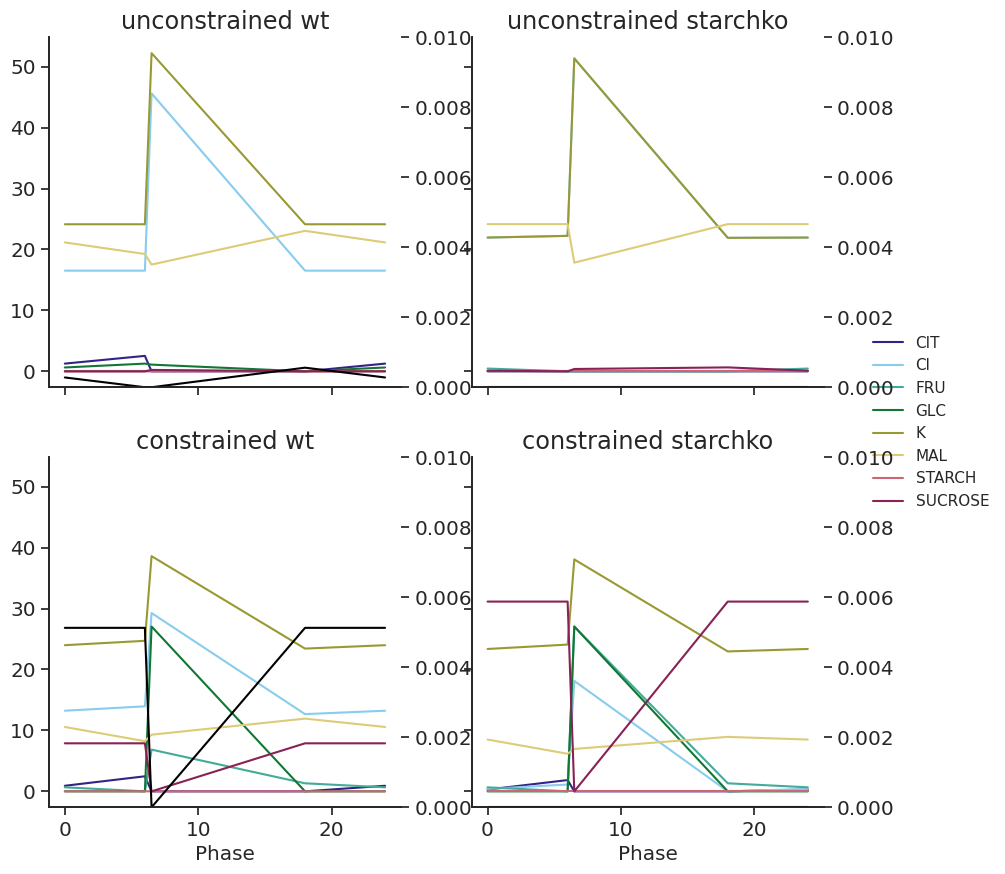

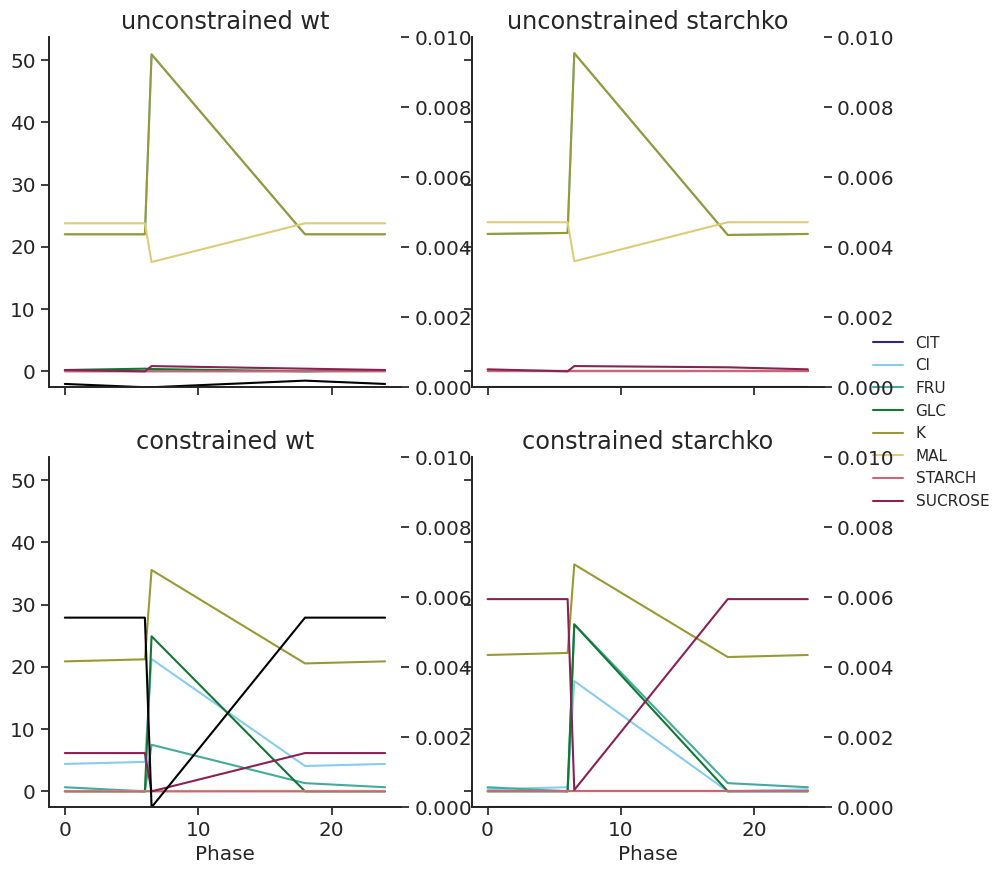

In [31]:
for light in ["blue", "white"]:
    plot_linkers(met_df_mm, light)

## Plotting before and after opening

In [32]:
def convert_starch_cols_to_per_gc(row_series, SuperModel, units):
    if row_series.name[1] == "STARCH":
        n_gcs = SuperModel.N_gcs
        row_series_moles = row_series * 10**-3
        moles_per_gc = row_series_moles / n_gcs
        row_series_converted_to_units = moles_per_gc * (1 / units)

        return row_series_converted_to_units

    else:
        return row_series

In [33]:
femtomoles = 10**-15
met_df_mm_starch_fmol_per_gc = met_df_mm.apply(
    convert_starch_cols_to_per_gc, args=[arabidopsis_supermodel, femtomoles], axis=1
)

In [34]:
met_df_mm_starch_fmol_per_gc

Light                   blue                                           \
ATPase         unconstrained                                            
Starch                    wt                         starchko           
Solution              fluxes minimum       maximum     fluxes minimum   
Phase Reaction                                                          
0.0   K            24.136132     NaN           NaN  21.955121     NaN   
      Cl           16.525132     NaN           NaN  21.954367     NaN   
      SUCROSE       0.000000     NaN           NaN   0.098507     NaN   
      GLC           0.634252     NaN           NaN   0.000000     NaN   
      FRU           0.000000     NaN           NaN   0.458382     NaN   
      MAL          21.155384     NaN           NaN  24.158591     NaN   
      CIT           1.268503     NaN           NaN   0.000000     NaN   
      STARCH        0.482031     NaN           NaN   0.000000     NaN   
6.0   K            24.136132     0.0  1.402629e+02  22.233565     0.0   
      Cl           16.525132     0.0  8.929067e+01  22.232812     0.0   
      SUCROSE       0.000000     0.0  1.785813e+02   0.000000     0.0   
      GLC           1.268503     0.0  1.785813e+02   0.000000     0.0   
      FRU           0.000000     0.0  1.785813e+02   0.000000     0.0   
      MAL          19.252629     0.0  6.449432e+01  24.158591     0.0   
      CIT           2.537007     0.0  4.943514e+01   0.000000     0.0   
      STARCH        0.000000     0.0  1.724138e+06   0.000000     0.0   
6.5   K            52.216008     0.0  1.528762e+02  51.358113     0.0   
      Cl           45.605310     0.0  1.082214e+02  51.357459     0.0   
      SUCROSE       0.234614     0.0  2.164428e+02   0.386395     0.0   
      GLC           1.101786     0.0  2.164428e+02   0.000000     0.0   
      FRU           0.000000     0.0  2.164428e+02   0.000000     0.0   
      MAL          17.519298     0.0  6.511682e+01  17.835664     0.0   
      CIT           0.000000     0.0  4.486908e+01   0.000218     0.0   
      STARCH        0.000000     0.0  0.000000e+00   0.000000     0.0   
18.0  K            24.136132     NaN           NaN  21.909670     NaN   
      Cl           16.525132     NaN           NaN  21.908917     NaN   
      SUCROSE       0.000000     NaN           NaN   0.647915     NaN   
      GLC           0.000000     NaN           NaN   0.000000     NaN   
      FRU           0.000000     NaN           NaN   0.000000     NaN   
      MAL          23.058139     NaN           NaN  24.158214     NaN   
      CIT           0.000000     NaN           NaN   0.000251     NaN   
      STARCH        0.964062     NaN           NaN   0.000000     NaN   
24.0  K            24.136132     NaN           NaN  21.955121     NaN   
      Cl           16.525132     NaN           NaN  21.954367     NaN   
      SUCROSE       0.000000     NaN           NaN   0.098507     NaN   
      GLC           0.634252     NaN           NaN   0.000000     NaN   
      FRU           0.000000     NaN           NaN   0.458382     NaN   
      MAL          21.155384     NaN           NaN  24.158591     NaN   
      CIT           1.268503     NaN           NaN   0.000000     NaN   
      STARCH        0.482031     NaN           NaN   0.000000     NaN   

Light                                                                  ...  \
ATPase                     constrained                                 ...   
Starch                              wt                       starchko  ...   
Solution           maximum      fluxes minimum     maximum     fluxes  ...   
Phase Reaction                                                         ...   
0.0   K                NaN   23.983912     NaN         NaN  23.364255  ...   
      Cl               NaN   13.230458     NaN         NaN   0.402977  ...   
      SUCROSE          NaN    7.881206     NaN         NaN  31.139003  ...   
      GLC              NaN    0.000000     NaN         NaN   0.000000  ...   
      FRU   

In [35]:
met_df_mm_starch_fmol_per_gc.xs("STARCH", level="Reaction").xs("fluxes", level="Solution", axis=1)

Light           blue                                       white           \
ATPase unconstrained          constrained          unconstrained            
Starch            wt starchko          wt starchko            wt starchko   
Phase                                                                       
0.0         0.482031      0.0    8.837963      0.0      0.162898      0.0   
6.0         0.000000      0.0    8.837963      0.0      0.000000      0.0   
6.5         0.000000      0.0    0.000000      0.0      0.000000      0.0   
18.0        0.964062      0.0    8.837963      0.0      0.325796      0.0   
24.0        0.482031      0.0    8.837963      0.0      0.162898      0.0   

Light                                nops                                
ATPase constrained          unconstrained          constrained           
Starch          wt starchko            wt starchko          wt starchko  
Phase                                                                    
0.0       9.340372      0.0           0.0      0.0     4.40705      0.0  
6.0       9.340372      0.0           0.0      0.0     4.40705      0.0  
6.5       0.000000      0.0           0.0      0.0     0.00000      0.0  
18.0      9.340372      0.0           0.0      0.0     4.40705      0.0  
24.0      9.340372      0.0           0.0      0.0     4.40705      0.0

/tmp/ipykernel_5249/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_5249/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_5249/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_5249/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_5249/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_

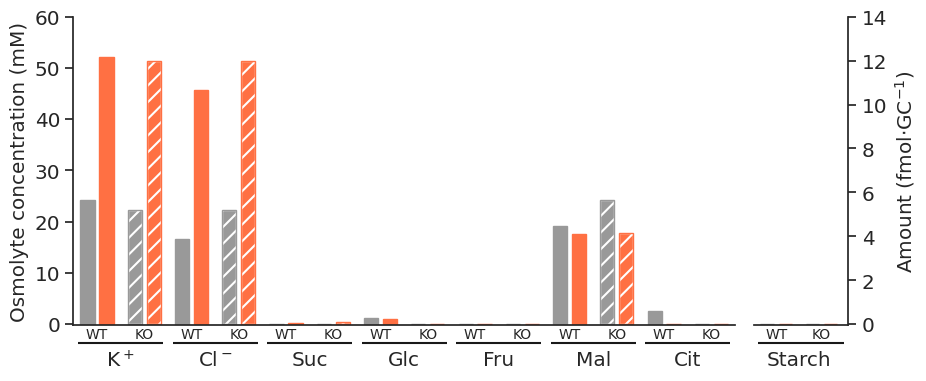

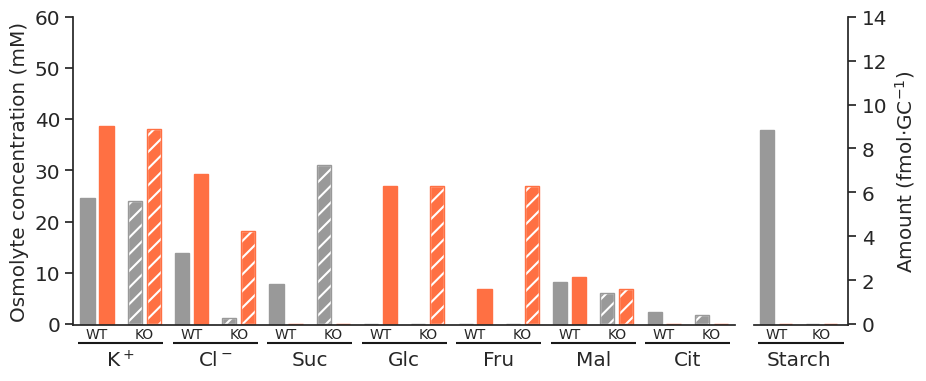

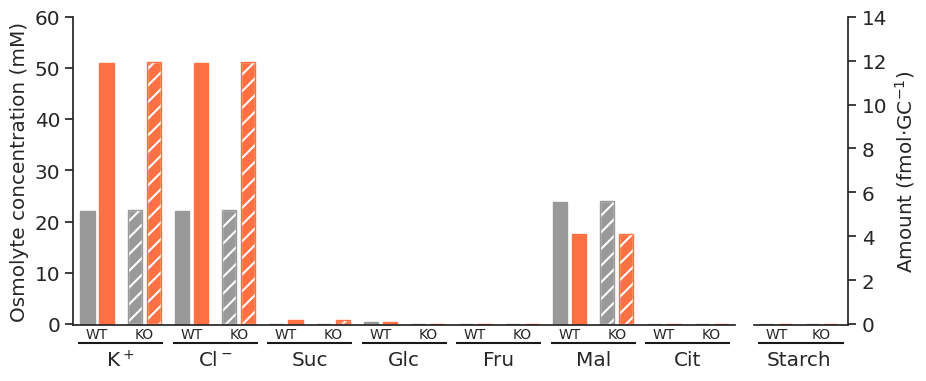

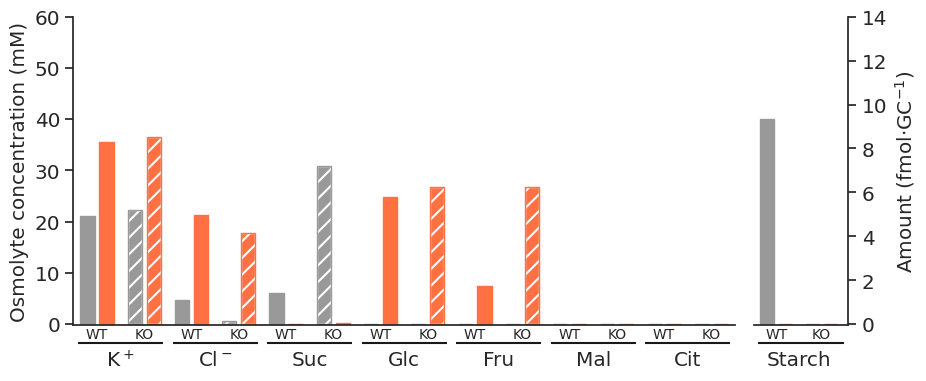

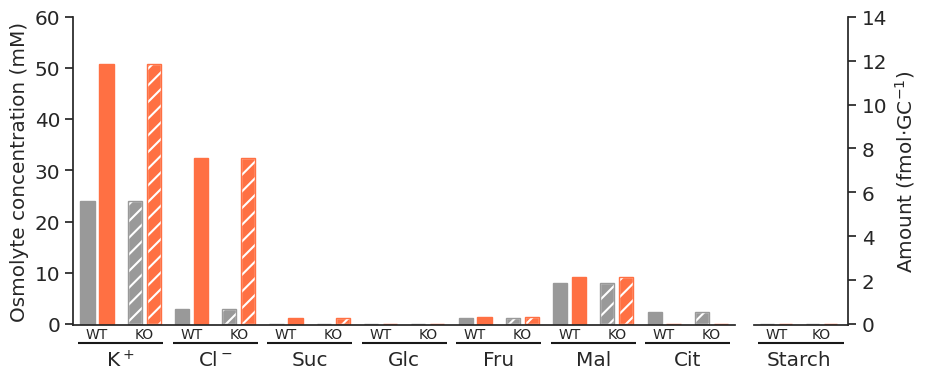

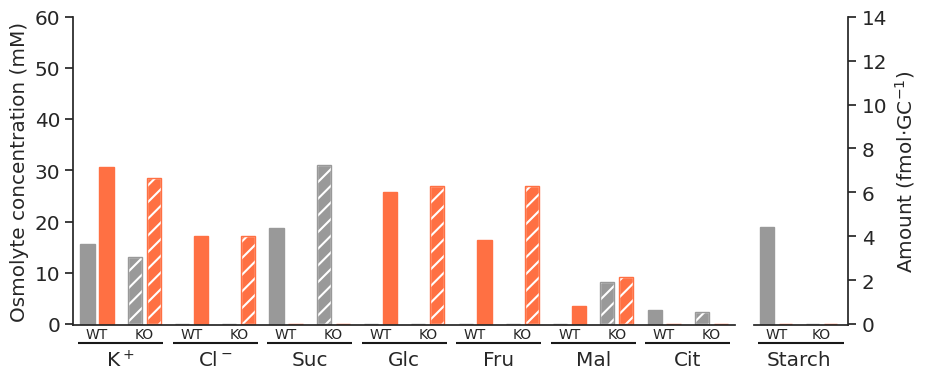

In [36]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
        fig = get_totals_plot(specific_df)
        plot_name = f"{light}_{atpase}"
        fig.savefig(
            f"../outputs/total_opening_plots/{plot_name}.svg",
            format="svg",
            bbox_inches="tight",
        )
        fig.savefig(
            f"../outputs/total_opening_plots/{plot_name}.png",
            format="png",
            bbox_inches="tight",
            dpi=300,
        )

## Flux maps

In [37]:
map_translation = {
    "": "Opening",
    "_1": "Night2",
    "_2": "Night1",
    "_3": "Day",
}

In [38]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        for starch in ["wt", "starchko"]:
            for map_suffix in ["", "_1", "_2", "_3"]:
                model_solution = solutions_df_unphased.loc[:, (light, atpase, starch, "fluxes")]
                flux_map = get_escher_map(
                    model_solution,
                    map=f"../inputs/map{map_suffix}.json",
                    json_model="../models/4_stage_GC.json",
                )
                flux_map_name = f"{light}_{atpase}_{starch}"
                flux_map.save_html(f"../outputs/escher_maps/{flux_map_name}_{map_translation[map_suffix]}.html")

In [39]:
linkers_met_dict = {
    "SUCROSE": "Suc",
    "GLC": "Glc",
    "FRU": "Fru",
    "MAL": "Mal",
    "CIT": "Cit",
    "L_ASPARTATE": "Asp",
    "SER": "Ser",
}

In [40]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("blue", "constrained", "wt", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm     0.000000   0.000000
            Vacuole      10.494282   0.000000
GLC         Cytoplasm     0.000000  81.128751
            Vacuole       0.000000   9.115033
FRU         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000   9.115033
MAL         Cytoplasm     0.000000  37.324138
            Vacuole      10.959741   0.000000
CIT         Cytoplasm     9.916585   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole       0.000000   0.000000
SER         Vacuole       0.000000   0.000000

In [41]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("blue", "constrained", "starchko", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm     0.000000   0.000000
            Vacuole      41.463387   0.000000
GLC         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000  36.013913
FRU         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000  36.013913
MAL         Cytoplasm     0.000000  27.957572
            Vacuole       8.209371   0.000000
CIT         Cytoplasm     7.428003   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole      57.476325  49.922294
SER         Vacuole       0.000000   0.000000

In [42]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("white", "constrained", "wt", "fluxes"),
].unstack(0)

Phase                         6.0        6.5
Reaction    Compartment                     
SUCROSE     Cytoplasm    8.249604   0.000000
            Vacuole      5.451526   0.000000
GLC         Cytoplasm    0.000000  85.740649
            Vacuole      0.000000   4.735040
FRU         Cytoplasm    0.000000  15.763814
            Vacuole      0.000000   4.735040
MAL         Cytoplasm    0.000000   0.000000
            Vacuole      0.000000   0.000000
CIT         Cytoplasm    0.000000   0.000000
            Vacuole      0.000000   0.000000
L_ASPARTATE Vacuole      0.000000   0.000000
SER         Vacuole      0.000000   0.000000

In [43]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("white", "constrained", "starchko", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm     0.000000   0.904148
            Vacuole      41.118249   0.000000
GLC         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000  35.714136
FRU         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000  35.714136
MAL         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000   0.000000
CIT         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole       0.000000   0.000000
SER         Vacuole       0.000000   0.000000

In [44]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("nops", "constrained", "wt", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm    75.690890   0.000000
            Vacuole       0.000000   0.000000
GLC         Cytoplasm     0.000000  80.131244
            Vacuole       0.000000   7.839376
FRU         Cytoplasm     0.000000  42.098882
            Vacuole       0.000000   7.839376
MAL         Cytoplasm     0.000000  14.534903
            Vacuole       0.000000   0.000000
CIT         Cytoplasm    11.156171   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole       0.000000   0.000000
SER         Vacuole       0.000000   0.000000

In [45]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("nops", "constrained", "starchko", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm    92.825784   0.000000
            Vacuole      10.686263   0.000000
GLC         Cytoplasm     0.000000  32.279609
            Vacuole       0.000000  25.311354
FRU         Cytoplasm     0.000000  32.279609
            Vacuole       0.000000  25.311354
MAL         Cytoplasm     0.000000  37.266070
            Vacuole      10.942690   0.000000
CIT         Cytoplasm     9.901155   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole       0.000000   0.000000
SER         Vacuole       0.000000   0.000000

In [46]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        for starch in ["wt", "starchko"]:
            print(f"{light}_{atpase}_{starch}")

            mets_to_include = [
                "SUCROSE",
                "GLC",
                "FRU",
                "MAL",
                "CIT",
                "L_ASPARTATE",
                "SER",
            ]
            test_df = linkers_df.loc[
                (
                    [6, 6.5],
                    mets_to_include,
                ),
                (light, atpase, starch, "fluxes"),
            ].unstack(0)
            test_df.columns = ["EoN", "30 mins"]
            test_df.index = pd.MultiIndex.from_tuples(
                [(linkers_met_dict[index[0]], index[1]) for index in test_df.index]
            )

            scaling = 0.4

            test_df = test_df * scaling

            if (test_df.loc[["Asp", "Ser"]] > 0.0000000001).sum().sum() > 0:
                aspser = True
                print(test_df)
            else:
                aspser = False
                print(test_df.loc[["Asp", "Ser"]])

            scale_conc = 50  # mM

            scaled_scale_conc = scale_conc * scaling

            map_name = f"{light}_{atpase}_{starch}"
            if starch == "wt":
                gc_path = getgcdiagram(
                    test_df,
                    map_name,
                    atpase,
                    starch,
                    scaled_scale_conc,
                    flipped=False,
                    #aspser=aspser,
                    aspser=False,
                    display_svg=True,
                    debug=False,
                    brokenaxis=False,
                )
            else:
                gc_path = getgcdiagram(
                    test_df,
                    map_name,
                    atpase,
                    starch,
                    scaled_scale_conc,
                    flipped=True,
                    #aspser=aspser,
                    aspser=False,
                    display_svg=True,
                    debug=False,
                    brokenaxis=False,
                )

            # doesn't seem to work with hatched
            # svg_code = open(gc_path, 'rt').read()
            # svg2png(bytestring=svg_code, write_to=f"../outputs/flux_maps/{map_name}.png", dpi=300)

blue_unconstrained_wt
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_unconstrained_starchko
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_constrained_wt
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_constrained_starchko
                     EoN    30 mins
Suc Cytoplasm   0.000000   0.000000
    Vacuole    16.585355   0.000000
Glc Cytoplasm   0.000000   0.000000
    Vacuole     0.000000  14.405565
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000  14.405565
Mal Cytoplasm   0.000000  11.183029
    Vacuole     3.283749   0.000000
Cit Cytoplasm   2.971201   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole    22.990530  19.968918
Ser Vacuole     0.000000   0.000000
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_unconstrained_wt
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_unconstrained_starchko
                     EoN    30 mins
Suc Cytoplasm   0.000000   1.362671
    Vacuole     0.000000   0.000000
Glc Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Mal Cytoplasm   0.000000  28.404813
    Vacuole    12.756363   0.000000
Cit Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole     0.000000   0.000000
Ser Vacuole    36.990356  32.128766
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_constrained_wt
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_constrained_starchko
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_unconstrained_wt
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_unconstrained_starchko
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_constrained_wt
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_constrained_starchko
             EoN  30 mins
Asp Vacuole  0.0      0.0
Ser Vacuole  0.0      0.0
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


In [47]:
blue_phloem_tx_overall_df = solutions_df.loc["Phloem_tx_overall", "blue"].xs("fluxes", level="Solution", axis=1)
white_phloem_tx_overall_df = solutions_df.loc["Phloem_tx_overall", "white"].xs("fluxes", level="Solution", axis=1)

In [48]:
blue_phloem_tx_overall_df_wt_unconstrained_corrected = blue_phloem_tx_overall_df - blue_phloem_tx_overall_df.iloc[0, 0]
blue_phloem_tx_overall_df_wt_unconstrained_corrected = blue_phloem_tx_overall_df_wt_unconstrained_corrected.mask(
    blue_phloem_tx_overall_df_wt_unconstrained_corrected > -0.0000000001, 0
)
blue_phloem_tx_overall_df_wt_unconstrained_corrected_fmol = (
    blue_phloem_tx_overall_df_wt_unconstrained_corrected / parameters_df.loc["N_gcs", "Value"] * 10**12
)

In [49]:
white_phloem_tx_overall_df_wt_unconstrained_corrected = (
    white_phloem_tx_overall_df - white_phloem_tx_overall_df.iloc[0, 0]
)
white_phloem_tx_overall_df_wt_unconstrained_corrected = white_phloem_tx_overall_df_wt_unconstrained_corrected.mask(
    white_phloem_tx_overall_df_wt_unconstrained_corrected > -0.0000000001, 0
)
white_phloem_tx_overall_df_wt_unconstrained_corrected_fmol = (
    white_phloem_tx_overall_df_wt_unconstrained_corrected / parameters_df.loc["N_gcs", "Value"] * 10**12
)

In [50]:
combined_fmol = pd.concat(
    [
        blue_phloem_tx_overall_df_wt_unconstrained_corrected_fmol,
        white_phloem_tx_overall_df_wt_unconstrained_corrected_fmol,
    ],
    keys=["Blue", "White"],
)
combined_fmol.index = combined_fmol.index.droplevel(1)
combined_fmol

ATPase unconstrained           constrained          
Starch            wt  starchko          wt  starchko
Blue             0.0 -0.000124   -0.027500 -0.043059
White            0.0 -0.000036   -0.030068 -0.047952

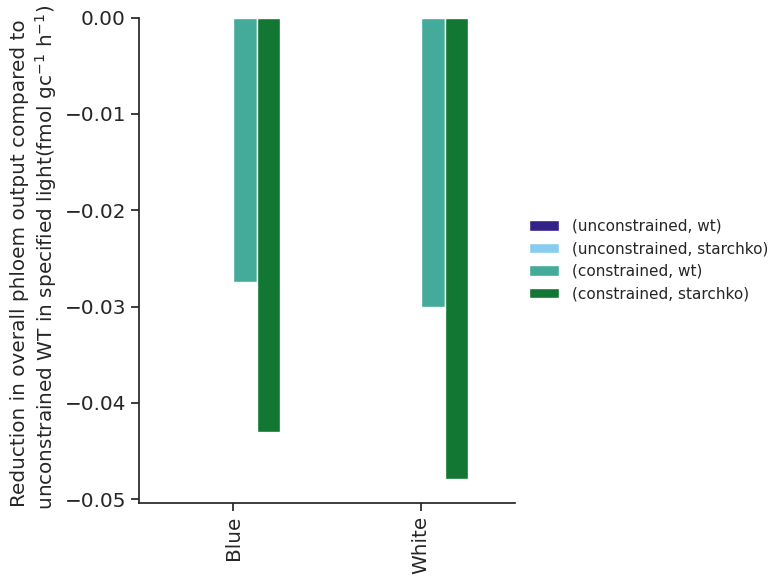

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
combined_fmol.plot.bar(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_ylabel(
    "Reduction in overall phloem output compared to \n unconstrained WT in specified light(fmol gc$^{-1}$ h$^{-1}$)"
)

fig.set_tight_layout(True)

fig.savefig("../outputs/efficiency_comparisons/efficiency_comparisons_compared.svg")
fig.savefig("../outputs/efficiency_comparisons/efficiency_comparisons_compared.png")

In [52]:
from functools import reduce

In [53]:
def multiply_series_by_coefficient(series_object, model, metabolite_id):
    reaction_id = series_object.name[0]
    coefficient = model.reactions.get_by_id(f"{reaction_id}_1").get_coefficient(f"{metabolite_id}_1")
    return coefficient * series_object

In [54]:
def get_metabolite_budget(solution_df, metabolite, model):
    metabolite_reactions_df = solution_df.loc[
        (
            [reaction.id[:-2] for reaction in four_stage_GC_model.metabolites.get_by_id(f"{metabolite}_1").reactions],
            slice(None),
        ),
        :,
    ]
    metabolite_consumed_produced_df = metabolite_reactions_df.apply(
        multiply_series_by_coefficient, args=[model, metabolite], axis=1
    )
    return metabolite_consumed_produced_df

In [55]:
def get_relevant_reaction_fluxes(
    solution_df,
    scenarios_to_drop=[("nops", "unconstrained"), ("white", "unconstrained")],
):
    solution_df = solution_df.xs("fluxes", level="Solution", axis=1)
    solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in
    solution_df = solution_df.loc[
        (abs(solution_df) > 0.00001).any(axis=1), :
    ]  # pick only reactions which have a flux in at least one scenario
    solution_df[abs(solution_df) < 0.00001] = 0  # ignore tiny fluxes from solver error

    return solution_df

In [56]:
def get_budget_for_multiple_metabolites(solution_df, metabolites, fba_model):
    metabolite_dfs = [get_metabolite_budget(solution_df, metabolite, fba_model) for metabolite in metabolites]
    metabolite_total_df = reduce(lambda a, b: a.add(b, fill_value=0), metabolite_dfs)
    metabolite_total_df = get_relevant_reaction_fluxes(metabolite_total_df)

    return metabolite_total_df

In [57]:
atp_metabolites = [metabolite.id for metabolite in four_stage_GC_model.metabolites if "ATP" in metabolite.id]
gc_atp_metabolites = [metabolite[:-2] for metabolite in atp_metabolites if "gc_2" in metabolite]
gc_atp_metabolites = [e for e in gc_atp_metabolites if e not in ("DATP_p_gc", "PHOSPHORIBOSYL_ATP_p_gc", "aDATP_p_gc")]
atp_budget_df = get_budget_for_multiple_metabolites(solutions_df, gc_atp_metabolites, four_stage_GC_model)

/tmp/ipykernel_5249/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


In [58]:
nadh_nadph_metabolites = [
    metabolite.id
    for metabolite in four_stage_GC_model.metabolites
    if "NADH" in metabolite.id or "NADPH" in metabolite.id
]
gc_nadh_nadph_metabolites = [metabolite[:-2] for metabolite in nadh_nadph_metabolites if "gc_2" in metabolite]
nadh_nadph_budget_df = get_budget_for_multiple_metabolites(solutions_df, gc_nadh_nadph_metabolites, four_stage_GC_model)

/tmp/ipykernel_5249/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


In [59]:
nadh_nadph_budget_df

Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000  0.000000   
                                       3          0.004593  0.004593   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2          0.000000  0.000000   
                                       3         -0.004054 -0.004049   
2OXOGLUTARATEDEH_RXN_m_gc              1          0.000000  0.000028   
...                                                    ...       ...   
NADPHox_p_tx_gc                        4         -0.000044 -0.000040   
PYRUVDEH_RXN_m_gc                      1          0.000050  0.000028   
                                       2          0.000238  0.000813   
                                       3          0.000000  0.000000   
                                       4          0.000050  0.000027   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000   
                                       3        0.004593  0.004593   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000   
                                       3       -0.003958 -0.003864   
2OXOGLUTARATEDEH_RXN_m_gc              1        0.000000  0.000000   
...                                                  ...       ...   
NADPHox_p_tx_gc                        4       -0.000040 -0.000040   
PYRUVDEH_RXN_m_gc                      1        0.000057  0.000057   
                                       2        0.000000  0.000000   
                                       3        0.000000  0.000000   
                                       4        0.000045  0.000034   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.004593  0.004593   
                                       3        0.004593  0.004593   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2       -0.002173 -0.002742   
                                       3       -0.003975 -0.003881   
2OXOGLUTARATEDEH_RXN_m_gc              1        0.000028  0.000028   
...                                                  ...       ...   
NADPHox_p_tx_gc                        4       -0.000040 -0.000040   
PYRUVDEH_RXN_m_gc                      1        0.000028  0.000028   
                                       2        0.000000  0.000000   
                                       3        0.000000  0.000000   
                                       4        0.000028  0.000028   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
2OXOGLUTARATEDEH_RXN_m_gc              1        0.000030  0.000031  
...                                                  ...       ...  
NADPHox_p_tx_gc                        4       -0.000039 -0.000039  
PYRUVDEH_RXN_m_gc                      1        0.000030  

In [60]:
atp_ordered_by_most_likely_importance = (
    abs(atp_budget_df).groupby(by="Reaction").sum().sum(axis=1).sort_values(ascending=False)
)
atp_budget_df_reordered = atp_budget_df.reindex(atp_ordered_by_most_likely_importance.index, level="Reaction")

In [61]:
nadh_nadph_ordered_by_most_likely_importance = (
    abs(nadh_nadph_budget_df).groupby(by="Reaction").sum().sum(axis=1).sort_values(ascending=False)
)
nadh_nadph_budget_df_reordered = nadh_nadph_budget_df.reindex(
    nadh_nadph_ordered_by_most_likely_importance.index, level="Reaction"
)

In [62]:
def convert_fluxes_to_per_guard_cell(series, super_model, units):
    return series * 10**-3 / super_model.N_gcs * (1 / units)

In [63]:
units = 10**-15  # fmol

In [64]:
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)

In [65]:
atp_budget_df_reordered_nmoles_gc

Light                                                   blue             \
ATPase                                         unconstrained              
Starch                                                    wt   starchko   
Reaction                                 Phase                            
Mitochondrial_ATP_Synthase_m_gc          1          0.674531   0.670681   
                                         2         21.155144  22.782568   
                                         3          1.583319   1.535555   
                                         4          0.674531   0.639287   
Plastidial_ATP_Synthase_p_gc             2          0.000000   0.000000   
                                         3         10.181458  10.181458   
PROTON_ATPase_c_gc                       1          0.000000   0.000000   
                                         2        -13.672773 -14.020420   
                                         3          0.000000   0.000000   
                                         4          0.000000   0.000000   
PROTONATP_rev_vc_gc                      2         -7.207194  -6.355538   
PHOSGLYPHOS_RXN_p_gc                     2          0.000000   0.000000   
                                         3         -6.988875  -6.980481   
ATPase_tx_gc                             1         -0.765303  -0.765303   
                                         2         -0.765303  -0.765303   
                                         3         -0.920514  -0.920514   
                                         4         -0.765303  -0.765303   
PHOSPHORIBULOKINASE_RXN_p_gc             2          0.000000   0.000000   
                                         3         -3.542150  -3.550111   
SUCCCOASYN_RXN_m_gc                      1          0.000000   0.048600   
                                         2          2.337713   1.401557   
                                         3          0.000000   0.000000   
                                         4          0.000000   0.046334   
UDPKIN_RXN_c_gc                          2         -0.205287  -0.338096   
                                         3         -0.229407  -0.265907   
                                         4          0.000000   0.034796   
FRUCTOKINASE_RXN_c_gc                    1          0.000000  -0.035270   
                                         3          0.000000   0.000000   
                                         4          0.000000   0.000000   
PHOSGLYPHOS_RXN_c_gc                     1          0.045386   0.048600   
                                         2         -0.821150  -1.352384   
                                         3          0.000000   0.000000   
                                         4          0.042778   0.046326   
PEPCARBOXYKIN_RXN_c_gc                   2         -0.975636  -2.499031   
PEPDEPHOS_RXN_c_gc                       1          0.040169   0.054839   
                                         2          0.154487   1.146647   
                                         3          0.000000   0.000000   
                                         4          0.042778   0.081122   
GLUC1PADENYLTRANS_RXN_p_gc               3         -0.083832   0.000000   
6PFRUCTPHOS_RXN_c_gc                     2          0.000000   0.000000   
PEPDEPHOS_RXN_p_gc                       3          0.000000   0.000000   
ADENYL_KIN_RXN_m_gc                      4          0.000000  -0.034796   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 4          0.000000  -0.034796   

Light                                                                  \
ATPase                                         constrained              
Starch                                                  wt   starchko   
Reaction                                 Phase                          
Mitochondrial_ATP_Synthase_m_gc          1        0.738808   0.738808   
                                         2       13.872292  10.198964   
                                    

Carbon movement df generation

In [66]:
apoplastic_linker_reactions = [
    reaction.id[:-2] for reaction in four_stage_GC_model.reactions if "a_Linker" in reaction.id
]
get_relevant_reaction_fluxes(solutions_df.loc[(apoplastic_linker_reactions, slice(None)), :])

/tmp/ipykernel_5249/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


Light                           blue                                 \
ATPase                 unconstrained           constrained            
Starch                            wt  starchko          wt starchko   
Reaction         Phase                                                
SUCROSE_a_Linker 3           0.00159  0.001729         0.0      0.0   
                 4           0.00000  0.000000         0.0      0.0   

Light                        white                 nops            
ATPase                 constrained          constrained            
Starch                          wt starchko          wt  starchko  
Reaction         Phase                                             
SUCROSE_a_Linker 3             0.0      0.0    0.000296  0.000369  
                 4             0.0      0.0    0.000148  0.000184

In [67]:
transfer_reactions = [reaction.id[:-2] for reaction in four_stage_GC_model.reactions if "ae_gc" in reaction.id]
transfer_reactions = [e for e in transfer_reactions if e not in ("WATER_ae_gc", "K_ae_gc", "Cl_ae_gc", "NITRATE_ae_gc")]
transfer_reactions = solutions_df.loc[(transfer_reactions, slice(None)), :]
transfer_reactions = get_relevant_reaction_fluxes(transfer_reactions)
transfer_reactions.loc[("GLC_ae_gc", 2), :] = 0
transfer_reactions

/tmp/ipykernel_5249/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


Light                        blue                                      white  \
ATPase              unconstrained          constrained           constrained   
Starch                         wt starchko          wt  starchko          wt   
Reaction      Phase                                                            
SUCROSE_ae_gc 1          0.000000  0.00000    0.000000  0.000000    0.000000   
              3         -0.000138 -0.00015    0.000151  0.000154    0.000118   
              4          0.000000  0.00000    0.000000  0.000000    0.000000   
GLC_ae_gc     3         -0.000024  0.00000   -0.000597 -0.000597   -0.000550   
              2          0.000000  0.00000    0.000000  0.000000    0.000000   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_gc 1      0.000000    0.000025  0.000031  
              3      0.000142    0.000302  0.000310  
              4      0.000000    0.000025  0.000031  
GLC_ae_gc     3     -0.000592   -0.000570 -0.000597  
              2      0.000000    0.000000  0.000000

In [68]:
transfer_reactions_me = [reaction.id[:-2] for reaction in four_stage_GC_model.reactions if "ae_me" in reaction.id]
transfer_reactions_me = [
    e
    for e in transfer_reactions_me
    if e
    not in (
        "WATER_ae_me",
        "K_ae_me",
        "Cl_ae_me",
        "NITRATE_ae_me",
        "SULFATE_ae_me",
        "AMMONIUM_ae_me",
    )
]
transfer_reactions_me = get_relevant_reaction_fluxes(solutions_df.loc[(transfer_reactions_me, slice(None)), :])
transfer_reactions_me

/tmp/ipykernel_5249/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_me 3          0.000000  0.000000   -0.000151 -0.000154   -0.000118   
              4          0.000265  0.000288    0.000000  0.000000    0.000000   
GLC_ae_me     3          0.000024  0.000000    0.000597  0.000597    0.000550   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_me 3     -0.000142   -0.000327 -0.000342  
              4      0.000000    0.000000  0.000000  
GLC_ae_me     3      0.000592    0.000570  0.000597

In [69]:
def adjust_for_hexose_equivalents(series_object):
    hexose_equivalents = {
        "GLC": 1,
        "SUCROSE": 2,
        "FRU": 1,
    }

    metabolite = series_object.name[0].split("_")[0]
    hexose_equivalent = hexose_equivalents[metabolite]

    return series_object * hexose_equivalent

In [70]:
from mmon_gcm.analysing import adjust_for_phases

In [71]:
transfer_reactions_me

Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_me 3          0.000000  0.000000   -0.000151 -0.000154   -0.000118   
              4          0.000265  0.000288    0.000000  0.000000    0.000000   
GLC_ae_me     3          0.000024  0.000000    0.000597  0.000597    0.000550   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_me 3     -0.000142   -0.000327 -0.000342  
              4      0.000000    0.000000  0.000000  
GLC_ae_me     3      0.000592    0.000570  0.000597

In [72]:
me_carbon_production_consumption = (
    transfer_reactions_me.apply(adjust_for_phases, args=[four_stage_GC_model], axis=1)
    .apply(adjust_for_hexose_equivalents, axis=1)
    .sum()
    * -1
)
me_carbon_production_consumption

Light  ATPase         Starch  
blue   unconstrained  wt         -0.003459
                      starchko   -0.003458
       constrained    wt         -0.003389
                      starchko   -0.003327
white  constrained    wt         -0.003610
                      starchko   -0.003543
nops   constrained    wt          0.000971
                      starchko    0.001012
dtype: float64

In [73]:
gc_carbon_production_consumption = (
    transfer_reactions.loc[["GLC_ae_gc", "SUCROSE_ae_gc"], :]
    .apply(adjust_for_phases, args=[four_stage_GC_model], axis=1)
    .apply(adjust_for_hexose_equivalents, axis=1)
    * -1
)
gc_carbon_production_consumption

Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
GLC_ae_gc     3          0.000280 -0.000000    0.006863  0.006863     0.00632   
              2         -0.000000 -0.000000   -0.000000 -0.000000    -0.00000   
SUCROSE_ae_gc 1         -0.000000 -0.000000   -0.000000 -0.000000    -0.00000   
              3          0.003179  0.003458   -0.003474 -0.003536    -0.00271   
              4         -0.000000 -0.000000   -0.000000 -0.000000    -0.00000   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
GLC_ae_gc     3      0.006806    0.006557  0.006863  
              2     -0.000000   -0.000000 -0.000000  
SUCROSE_ae_gc 1     -0.000000   -0.000296 -0.000369  
              3     -0.003263   -0.006935 -0.007137  
              4     -0.000000   -0.000296 -0.000369

In [74]:
((0.006863-0.003474)+(0.006863-0.003536))/2

0.003358

In [75]:
((0.00632-0.00271)+(0.006806-0.003263))/2

0.0035765000000000003

In [76]:
0.0035765000000000003/0.003358

1.065068493150685

In [77]:
(0.006863-0.003474)/(0.006863-0.003536)

1.0186354072738202

In [78]:
(0.00632-0.00271)/(0.006806-0.003263)

1.0189105278012982

In [79]:
gc_carbon_production_consumption_nmoles_gc = gc_carbon_production_consumption.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)

In [80]:
atp_colours = {
    "6PFRUCTPHOS_RXN_c_gc": [6, 6],  # phosphofructokinase glycolysis
    "FRUCTOKINASE_RXN_c_gc": [6, 6],  # fructokinase glycolysis
    "GLUC1PADENYLTRANS_RXN_p_gc": [8, 8],  # glc1p -> adp glc (starch synthesis)
    "GLY3KIN_RXN_p_gc": [6, 6],  # g3p -> glycerate (carbon degradation)
    "Mitochondrial_ATP_Synthase_m_gc": [7, 7],  # mitochondrial atp synthase
    "PEPCARBOXYKIN_RXN_c_gc": [6, 6],  # OAA -> pyruvate (mal deg)
    "PEPDEPHOS_RXN_c_gc": [6, 6],  # PEP -> pyruvate
    "PEPDEPHOS_RXN_p_gc": [6, 6],  # PEP -> pyruvate
    "PHOSGLYPHOS_RXN_c_gc": [2, 6],  # DPG -> G3p (glycolysis)
    "PHOSGLYPHOS_RXN_p_gc": [4, 4],  # DPG -> G3p (glycolysis)
    "PHOSPHORIBULOKINASE_RXN_p_gc": [4, 4],  # calvin cycle
    "PROTONATP_rev_vc_gc": [0, 0],  # tonoplastic proton pump
    "PROTON_ATPase_c_gc": [1, 1],  # plasma membrane proton pump
    "Plastidial_ATP_Synthase_p_gc": [3, 3],  # plastidial atp_synthase
    "SUCCCOASYN_RXN_m_gc": [6, 6],  # TCA cycle
    "UDPKIN_RXN_c_gc": [2, 2],  # atp->utp, sucrose synthesis
    "GLUCOKIN_RXN_c_gc": [9, 9],
    "ATP_ADP_mc_gc": [9, 9],  # ATP shuttle
    "ATPase_tx_gc": [9, 9],  # maintenance
    "PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc": [9, 9],
    "ADENYL_KIN_RXN_m_gc": [9, 9],
    "6PFRUCTPHOS_RXN_p_gc": [9, 9],
}

nadh_nadph_colours = {
    "1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc": [3, 3],  # ps
    "1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc": [4, 4],  # ps
    "2OXOGLUTARATEDEH_RXN_m_gc": [6, 6],  # tca
    "GAPOXNPHOSPHN_RXN_c_gc": [2, 6],  # glycolysis or gluconeogenesis
    "GAPOXNPHOSPHN_RXN_p_gc": [4, 4],  # calvin cycle but nadh
    "HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc": [
        5,
        5,
    ],  # OH_PYR_x -> Glycerate_x to do with serine/aspartate metabolism
    "ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc": [6, 6],  # tca
    "MALATE_DEHYDROGENASE_NADPs_RXN_p_gc": [9, 9],  # shuttle
    "MALATE_DEH_RXN_c_gc": [
        9,
        6,
    ],  # malate degradation when forward but also shuttle in reverse
    "MALATE_DEH_RXN_m_gc": [9, 9],  # can be tca but mainly shuttle
    "MALATE_DEH_RXN_p_gc": [9, 9],  # shuttle
    "MALATE_DEH_RXN_x_gc": [9, 9],  # shuttle
    "MALIC_NAD_RXN_m_gc": [6, 6],  # malate degradation (al->pyr)
    "NADH_DEHYDROG_A_RXN_mi_gc": [7, 7],  # complex 1 (TC)
    #"PGLYCDEHYDROG_RXN_p_gc": [5, 5],  # ser_synthesis from g3p
    "PYRUVDEH_RXN_m_gc": [6, 6],  # pyruvate degradation
    "ISOCITDEH_RXN_c_gc": [6, 6],  # tca nadp
    "6PGLUCONDEHYDROG_RXN_p_gc": [9, 9],  # PPP
    "NADPHox_c_tx_gc": [9, 9],
    "NADPHox_p_tx_gc": [9, 9],
    "GLU6PDEHYDROG_RXN_c_gc": [9, 9],
    "6PGLUCONDEHYDROG_RXN_c_gc": [9, 9],
    "GLU6PDEHYDROG_RXN_p_gc": [9, 9],
    "MALIC_NADP_RXN_c_gc": [9, 9],
}

reaction_colours = {**atp_colours, **nadh_nadph_colours}
for reaction, colour_number in reaction_colours.items():
    for i, reverse_forward in enumerate(colour_number):
        if reverse_forward == 9:
            reaction_colours[reaction][i] = "#DDDDDD"
        else:
            reaction_colours[reaction][i] = colours[reverse_forward]

In [81]:
colours_legend = {
    "Tonoplast membrane ATPase": 0,
    "Plasma membrane ATPase": 1,
    "Sucrose/Glucose synthesis": 2,
    "Plastid/Photosynthesis": 3,
    "Carbon fixation": 4,
    #"Serine Synthesis": 5,
    "Carbon degradation\n(Glycolysis, TCA etc.)": 6,
    "ETC/Mitochondrial\nATP Synthase": 7,
    "Starch synthesis": 8,
    "Other e.g. shuttles, maintenance": 9,
}
for category, colour_number in colours_legend.items():
    if colour_number == 9:
        colours_legend[category] = "#DDDDDD"
    else:
        colours_legend[category] = colours[colour_number]

In [82]:
carbon_colours = {
    "SUCROSE_ae_gc": colours[2],
    "GLC_ae_gc": colours[6],
    "FRU_ae_gc": colours[4],
}

In [83]:
legend_colours = {
    "Glucose": colours[6],
    "Sucrose": colours[2],
}

In [84]:
atp_budget_df_reordered_nmoles_gc.index

MultiIndex([(         'Mitochondrial_ATP_Synthase_m_gc', 1),
            (         'Mitochondrial_ATP_Synthase_m_gc', 2),
            (         'Mitochondrial_ATP_Synthase_m_gc', 3),
            (         'Mitochondrial_ATP_Synthase_m_gc', 4),
            (            'Plastidial_ATP_Synthase_p_gc', 2),
            (            'Plastidial_ATP_Synthase_p_gc', 3),
            (                      'PROTON_ATPase_c_gc', 1),
            (                      'PROTON_ATPase_c_gc', 2),
            (                      'PROTON_ATPase_c_gc', 3),
            (                      'PROTON_ATPase_c_gc', 4),
            (                     'PROTONATP_rev_vc_gc', 2),
            (                    'PHOSGLYPHOS_RXN_p_gc', 2),
            (                    'PHOSGLYPHOS_RXN_p_gc', 3),
            (                            'ATPase_tx_gc', 1),
            (                            'ATPase_tx_gc', 2),
            (                            'ATPase_tx_gc', 3),
            (           

In [85]:
nadh_nadph_budget_df_reordered_nmoles_gc

Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000  0.000000   
                                       3          7.918912  7.918912   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2          0.000000  0.000000   
                                       3         -6.988875 -6.980481   
NADH_DEHYDROG_A_RXN_mi_gc              1         -0.221714 -0.194400   
...                                                    ...       ...   
6PGLUCONDEHYDROG_RXN_p_gc              1          0.034952  0.034417   
                                       3          0.000000  0.000000   
                                       4          0.037561  0.034796   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000  0.000000   
MALATE_DEH_RXN_p_gc                    3          0.000000  0.000000   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000   
                                       3        7.918912  7.918912   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000   
                                       3       -6.824133 -6.661311   
NADH_DEHYDROG_A_RXN_mi_gc              1       -0.246269 -0.246269   
...                                                  ...       ...   
6PGLUCONDEHYDROG_RXN_p_gc              1        0.034308  0.034308   
                                       3        0.000000  0.000000   
                                       4        0.034319  0.034329   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000  0.000000   
MALATE_DEH_RXN_p_gc                    3        0.000000  0.000000   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        7.918912  7.918912   
                                       3        7.918912  7.918912   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2       -3.746772 -4.727792   
                                       3       -6.853493 -6.690779   
NADH_DEHYDROG_A_RXN_mi_gc              1       -0.196388 -0.196388   
...                                                  ...       ...   
6PGLUCONDEHYDROG_RXN_p_gc              1        0.034334  0.034334   
                                       3        0.000000  0.000000   
                                       4        0.034334  0.034334   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000  0.000000   
MALATE_DEH_RXN_p_gc                    3        0.000000  0.000000   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
NADH_DEHYDROG_A_RXN_mi_gc              1       -0.204523 -0.212064  
...                                                  ...       ...  
6PGLUCONDEHYDROG_RXN_p_gc              1        0.033995  0.033681  
                                       3        0.019738  

In [86]:
color_order = [
    [nadh_nadph_colours[reaction][1], reaction] for reaction in nadh_nadph_budget_df_reordered_nmoles_gc.index.levels[0]
]
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered_nmoles_gc.loc[
    pd.DataFrame(color_order).sort_values(by=[0, 1]).loc[:, 1].values
]

In [87]:
color_order = [[atp_colours[reaction][1], reaction] for reaction in atp_budget_df_reordered_nmoles_gc.index.levels[0]]
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered_nmoles_gc.loc[
    pd.DataFrame(color_order).sort_values(by=[0, 1]).loc[:, 1].values
]

In [88]:
atp_budget_df_reordered_nmoles_gc.drop("nops", axis=1).loc[("Plastidial_ATP_Synthase_p_gc", 3)].mean()

/tmp/ipykernel_5249/544428024.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  atp_budget_df_reordered_nmoles_gc.drop("nops", axis=1).loc[("Plastidial_ATP_Synthase_p_gc", 3)].mean()


10.181457681507931

In [89]:
(abs(nadh_nadph_budget_df_reordered_nmoles_gc) / 2).sum()

Light  ATPase         Starch  
blue   unconstrained  wt          16.203381
                      starchko    17.776331
       constrained    wt          13.499894
                      starchko    12.706482
white  constrained    wt          21.462877
                      starchko    20.644570
nops   constrained    wt           7.283849
                      starchko     5.903313
dtype: float64

In [90]:
nadh_nadph_budget_df_reordered_nmoles_gc

Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000  0.000000   
                                       3          7.918912  7.918912   
NADH_DEHYDROG_A_RXN_mi_gc              1         -0.221714 -0.194400   
                                       2         -5.649087 -6.753255   
                                       3         -0.527773 -0.511852   
...                                                    ...       ...   
NADPHox_c_tx_gc                        4         -0.179979 -0.185509   
NADPHox_p_tx_gc                        1         -0.069905 -0.068834   
                                       2          0.000000  0.000000   
                                       3         -0.306838 -0.306838   
                                       4         -0.075122 -0.069592   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000   
                                       3        7.918912  7.918912   
NADH_DEHYDROG_A_RXN_mi_gc              1       -0.246269 -0.246269   
                                       2       -3.498128 -2.556250   
                                       3       -0.747145 -0.920205   
...                                                  ...       ...   
NADPHox_c_tx_gc                        4       -0.186464 -0.186443   
NADPHox_p_tx_gc                        1       -0.068616 -0.068616   
                                       2        0.000000  0.000000   
                                       3       -0.306838 -0.306838   
                                       4       -0.068637 -0.068658   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        7.918912  7.918912   
                                       3        7.918912  7.918912   
NADH_DEHYDROG_A_RXN_mi_gc              1       -0.196388 -0.196388   
                                       2       -3.865302 -2.884282   
                                       3       -0.758581 -0.921294   
...                                                  ...       ...   
NADPHox_c_tx_gc                        4       -0.186433 -0.186433   
NADPHox_p_tx_gc                        1       -0.068668 -0.068668   
                                       2       -0.306838 -0.306838   
                                       3       -0.306838 -0.306838   
                                       4       -0.068668 -0.068668   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
NADH_DEHYDROG_A_RXN_mi_gc              1       -0.204523 -0.212064  
                                       2       -3.967292 -3.492290  
                                       3       -0.592577 -0.672074  
...                                                  ...       ...  
NADPHox_c_tx_gc                        4       -0.187111 -0.187739  
NADPHox_p_tx_gc                        1       -0.067990 -

In [91]:
(abs(nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), :])/2).sum()

Light  ATPase         Starch  
blue   unconstrained  wt          8.446685
                      starchko    8.430763
       constrained    wt          8.666056
                      starchko    8.839116
white  constrained    wt          8.677492
                      starchko    8.840206
nops   constrained    wt          0.984348
                      starchko    1.115560
dtype: float64

In [92]:
nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), :]

Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3          7.918912  7.918912   
NADH_DEHYDROG_A_RXN_mi_gc              3         -0.527773 -0.511852   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3         -6.988875 -6.980481   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000  0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3          0.000000  0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3          0.000000  0.000000   
ISOCITDEH_RXN_c_gc                     3          0.000000  0.000000   
MALATE_DEH_RXN_c_gc                    3          0.000000  0.000000   
PYRUVDEH_RXN_m_gc                      3          0.000000  0.000000   
6PGLUCONDEHYDROG_RXN_c_gc              3          0.000000  0.000000   
6PGLUCONDEHYDROG_RXN_p_gc              3          0.000000  0.000000   
GLU6PDEHYDROG_RXN_c_gc                 3          0.000000  0.000000   
GLU6PDEHYDROG_RXN_p_gc                 3          0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3         -0.623199 -0.631593   
MALATE_DEH_RXN_m_gc                    3          0.527773  0.511852   
MALATE_DEH_RXN_p_gc                    3          0.000000  0.000000   
MALIC_NADP_RXN_c_gc                    3          0.000000  0.000000   
NADPHox_c_tx_gc                        3          0.000000  0.000000   
NADPHox_p_tx_gc                        3         -0.306838 -0.306838   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        7.918912  7.918912   
NADH_DEHYDROG_A_RXN_mi_gc              3       -0.747145 -0.920205   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3       -6.824133 -6.661311   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000  0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.000000  0.000000   
ISOCITDEH_RXN_c_gc                     3        0.000000  0.000000   
MALATE_DEH_RXN_c_gc                    3        0.000000  0.000000   
PYRUVDEH_RXN_m_gc                      3        0.000000  0.000000   
6PGLUCONDEHYDROG_RXN_c_gc              3        0.000000  0.000000   
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000  0.000000   
GLU6PDEHYDROG_RXN_c_gc                 3        0.000000  0.000000   
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3       -0.787941 -0.950763   
MALATE_DEH_RXN_m_gc                    3        0.747145  0.920205   
MALATE_DEH_RXN_p_gc                    3        0.000000  0.000000   
MALIC_NADP_RXN_c_gc                    3        0.000000  0.000000   
NADPHox_c_tx_gc                        3        0.000000  0.000000   
NADPHox_p_tx_gc                        3       -0.306838 -0.306838   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        7.918912  7.918912   
NADH_DEHYDROG_A_RXN_mi_gc              3       -0.758581 -0.921294   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3       -6.853493 -6.690779   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000  0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.000000  0.000000   
ISOCITDEH_RXN_c_gc              

In [93]:
((0.984348+1.115560)/2) / ((8.446685+8.430763+8.666056+8.839116+8.677492+8.840206)/6)

0.12138122159482721

In [94]:
((0.984348+1.115560)/2) / ((8.666056+8.839116+8.677492+8.840206)/4)

0.11991638606430598

In [95]:
nops_nadph_3 = nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), "nops"].index

In [96]:
colours_legend_iv = {v: k for k, v in colours_legend.items()}

In [97]:
nops_nadph_3_df = nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), "nops"]

In [98]:
nops_nadph_3

MultiIndex([('1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc', 3),
            (             'NADH_DEHYDROG_A_RXN_mi_gc', 3),
            ('1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc', 3),
            (                'GAPOXNPHOSPHN_RXN_p_gc', 3),
            (             '2OXOGLUTARATEDEH_RXN_m_gc', 3),
            (                'GAPOXNPHOSPHN_RXN_c_gc', 3),
            (                    'ISOCITDEH_RXN_c_gc', 3),
            (                   'MALATE_DEH_RXN_c_gc', 3),
            (                     'PYRUVDEH_RXN_m_gc', 3),
            (             '6PGLUCONDEHYDROG_RXN_c_gc', 3),
            (             '6PGLUCONDEHYDROG_RXN_p_gc', 3),
            (                'GLU6PDEHYDROG_RXN_c_gc', 3),
            (                'GLU6PDEHYDROG_RXN_p_gc', 3),
            (   'MALATE_DEHYDROGENASE_NADPs_RXN_p_gc', 3),
            (                   'MALATE_DEH_RXN_m_gc', 3),
            (                   'MALATE_DEH_RXN_p_gc', 3),
            (                   'MALIC_NADP_RXN_c_gc', 3

In [99]:
nops_nadph_3_reactions = [i[0] for i in nops_nadph_3]

In [100]:
descriptions = []
for reaction in nops_nadph_3_reactions:
    descriptions.append(colours_legend_iv[nadh_nadph_colours[reaction][0]].replace("\n", ""))

In [101]:
nops_nadph_3_df.loc[:, "Description"] = descriptions

In [102]:
nops_nadph_3_df

ATPase                                       constrained            \
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.000000  0.000000   
NADH_DEHYDROG_A_RXN_mi_gc              3       -0.592577 -0.672074   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.136670  0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.090775  0.106920   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.000000  0.188385   
ISOCITDEH_RXN_c_gc                     3        0.090775  0.106920   
MALATE_DEH_RXN_c_gc                    3        0.000000 -0.188385   
PYRUVDEH_RXN_m_gc                      3        0.182566  0.188385   
6PGLUCONDEHYDROG_RXN_c_gc              3        0.039477  0.049394   
6PGLUCONDEHYDROG_RXN_p_gc              3        0.019738  0.024697   
GLU6PDEHYDROG_RXN_c_gc                 3        0.039477  0.049394   
GLU6PDEHYDROG_RXN_p_gc                 3        0.019738  0.024697   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.000000  0.000000   
MALATE_DEH_RXN_m_gc                    3        0.319236  0.376769   
MALATE_DEH_RXN_p_gc                    3       -0.136670  0.000000   
MALIC_NADP_RXN_c_gc                    3        0.045896  0.000000   
NADPHox_c_tx_gc                        3       -0.215624 -0.205707   
NADPHox_p_tx_gc                        3       -0.039477 -0.049394   

ATPase                                                                     Description  
Starch                                                                                  
Reaction                               Phase                                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3                        Plastid/Photosynthesis  
NADH_DEHYDROG_A_RXN_mi_gc              3                 ETC/MitochondrialATP Synthase  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3                               Carbon fixation  
GAPOXNPHOSPHN_RXN_p_gc                 3                               Carbon fixation  
2OXOGLUTARATEDEH_RXN_m_gc              3      Carbon degradation(Glycolysis, TCA etc.)  
GAPOXNPHOSPHN_RXN_c_gc                 3                     Sucrose/Glucose synthesis  
ISOCITDEH_RXN_c_gc                     3      Carbon degradation(Glycolysis, TCA etc.)  
MALATE_DEH_RXN_c_gc                    3              Other e.g. shuttles, maintenance  
PYRUVDEH_RXN_m_gc                      3      Carbon degradation(Glycolysis, TCA etc.)  
6PGLUCONDEHYDROG_RXN_c_gc              3              Other e.g. shuttles, maintenance  
6PGLUCONDEHYDROG_RXN_p_gc              3              Other e.g. shuttles, maintenance  
GLU6PDEHYDROG_RXN_c_gc                 3              Other e.g. shuttles, maintenance  
GLU6PDEHYDROG_RXN_p_gc                 3              Other e.g. shuttles, maintenance  
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3              Other e.g. shuttles, maintenance  
MALATE_DEH_RXN_m_gc                    3              Other e.g. shuttles, maintenance  
MALATE_DEH_RXN_p_gc                    3              Other e.g. shuttles, maintenance  
MALIC_NADP_RXN_c_gc                    3              Other e.g. shuttles, maintenance  
NADPHox_c_tx_gc                        3              Other e.g. shuttles, maintenance  
NADPHox_p_tx_gc                        3              Other e.g. shuttles, maintenance

In [103]:
atp_budget_df_reordered_nmoles_gc.columns

MultiIndex([( 'blue', 'unconstrained',       'wt'),
            ( 'blue', 'unconstrained', 'starchko'),
            ( 'blue',   'constrained',       'wt'),
            ( 'blue',   'constrained', 'starchko'),
            ('white',   'constrained',       'wt'),
            ('white',   'constrained', 'starchko'),
            ( 'nops',   'constrained',       'wt'),
            ( 'nops',   'constrained', 'starchko')],
           names=['Light', 'ATPase', 'Starch'])

In [104]:
gc_carbon_production_consumption_nmoles_gc = gc_carbon_production_consumption_nmoles_gc.loc[:, gc_carbon_production_consumption_nmoles_gc.columns.get_level_values(1) != 'unconstrained']

In [105]:
gc_carbon_production_consumption_nmoles_gc

Light                      blue                  white                   nops  \
ATPase              constrained            constrained            constrained   
Starch                       wt   starchko          wt   starchko          wt   
Reaction      Phase                                                             
GLC_ae_gc     3       11.832822  11.832821   10.896129  11.734326   11.305022   
              2       -0.000000  -0.000000   -0.000000  -0.000000   -0.000000   
SUCROSE_ae_gc 1       -0.000000  -0.000000   -0.000000  -0.000000   -0.510755   
              3       -5.989716  -6.096542   -4.672668  -5.625923  -11.957518   
              4       -0.000000  -0.000000   -0.000000  -0.000000   -0.510754   

Light                           
ATPase                          
Starch                starchko  
Reaction      Phase             
GLC_ae_gc     3      11.832822  
              2      -0.000000  
SUCROSE_ae_gc 1      -0.636193  
              3     -12.305836  
              4      -0.636193

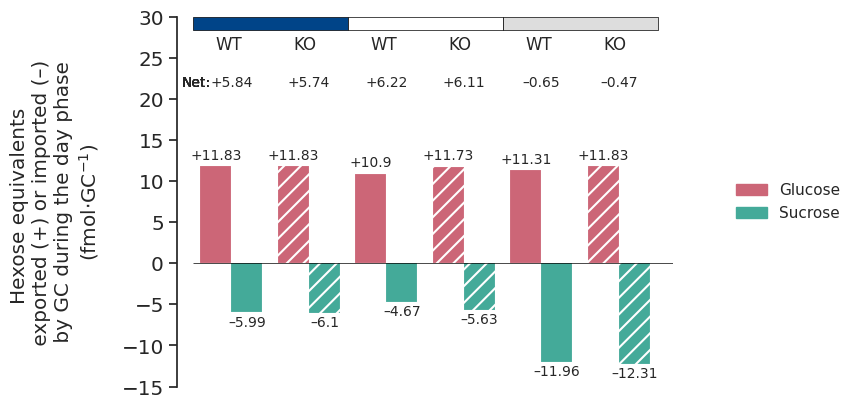

In [106]:
metabolites = ["ATP", "NAD(P)H"]
phases = ["Opening", "Day"]
hatches = {"wt": None, "starchko": "//"}
atpase_labelling = {"unconstrained": "–", "constrained": "+"}

fig, ax = plt.subplots(1, 1, sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1)

colour_rectangles_thickness = 4 / (75 * 2)

y_lim_for_hexose = 49

for x1, x2, colour in zip([-0.5, 1.5, 3.5], [1.5, 3.5, 5.5], ["#004488", "white", "#DDDDDD"]):
    ax.fill_betweenx(
        [30 - colour_rectangles_thickness * 30 * 2, 30],
        x1,
        x2,
        alpha=1,
        color=colour,
        linewidth=0.5,
        edgecolor="black",
    )
for i in range(6):
    if i % 2 == 0:
        ax.text(i-0.2, 30-4, "WT")
    else:
        ax.text(i-0.2, 30-4, "KO")

phase = 3
for i, scenario in enumerate(gc_carbon_production_consumption_nmoles_gc.columns):
    positive_bottom = 0
    negative_top = 0
    scenario_df = gc_carbon_production_consumption_nmoles_gc.xs(phase, level="Phase").loc[:, scenario]
    for reaction in scenario_df.index:
        value = scenario_df.loc[reaction]
        if value > 0.00001:
            ax.bar(
                i,
                value,
                bottom=positive_bottom,
                color=carbon_colours[reaction],
                linewidth=0.1,
                hatch=hatches[scenario[2]],
                align="edge",
                width=-0.4,
            )
            positive_bottom += value
        elif value < 0.00001:
            ax.bar(
                i,
                value,
                bottom=negative_top,
                color=carbon_colours[reaction],
                linewidth=0.1,
                hatch=hatches[scenario[2]],
                align="edge",
                width=0.4,
            )
            negative_top += abs(value)
    if positive_bottom == 0:
        ax.bar(
            i,
            0.3,
            bottom=0,
            color=carbon_colours[reaction],
            linewidth=0.1,
            hatch=hatches[scenario[2]],
            align="edge",
            width=-0.4,
        )
    if negative_top == 0:
        ax.bar(
            i,
            0.3,
            bottom=0,
            color=carbon_colours[reaction],
            linewidth=0.1,
            hatch=hatches[scenario[2]],
            align="edge",
            width=0.4,
        )
    if positive_bottom > 0:
        ax.text(
            i - 0.2,
            positive_bottom + 0.5,
            f"+{round(positive_bottom, 2)}",
            ha="center",
            va="bottom",
            size="small",
            #rotation=90,
        )
    if negative_top > 0:
        ax.text(
            i + 0.2,
            - negative_top - 2,
            f"–{round(negative_top, 2)}",
            ha="center",
            va="bottom",
            size="small",
            #rotation=90,
        )
    if positive_bottom > 0 and negative_top > 0:
        net_value = round(positive_bottom - negative_top, 2)
        if net_value < 0:
            ax.text(
                i - 0.0,
                22,
                f"–{abs(net_value)}",
                ha="center",
                va="center",
                size="small",
            )
        else:
            ax.text(
                i - 0.0,
                22,
                f"+{net_value}",
                ha="center",
                va="center",
                size="small",
            )
    ax.text(-0.45, 22, "Net:", ha="center", va="center", size="small")


patchList = []
for key in legend_colours:
    data_key = mpatches.Patch(color=legend_colours[key], label=key)
    patchList.append(data_key)

ax.legend(handles=patchList, loc="center left", bbox_to_anchor=(1.1, 0.5))


ax.set_xlim(-0.7, 5.7)
ax.set_ylim(-15, 30)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_bounds(-15, 30)
ax.set_xticks([])  # range(len(budget_df.columns)))
ax.set_xticklabels([])  # [atpase_labelling[scenario[1]] for scenario in budget_df.columns])

ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

ax.set_ylabel(
    "Hexose equivalents \n exported (+) or imported (–) \n by GC during the day phase \n" r"(fmol$\cdot$GC$^{-1}$)",
    labelpad=15,
)

#ax.set_title('Day', pad=10)

# fig.text(-0.02,0.25, "Hexose equivalents imported (+) \n or exported (-) by GC " r"(nmoles$\cdot$GC$^{-1}$)", rotation=90, va="center", ha="center", size="large")

fig.savefig(f"../plant_cell_paper/figure_6.svg", bbox_inches="tight")
fig.savefig(f"../plant_cell_paper/figure_6.png", dpi=300, bbox_inches="tight")

In [107]:
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered_nmoles_gc.loc[:, atp_budget_df_reordered_nmoles_gc.columns.get_level_values(1) != 'unconstrained']

In [108]:
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered_nmoles_gc.loc[:, nadh_nadph_budget_df_reordered_nmoles_gc.columns.get_level_values(1) != 'unconstrained']

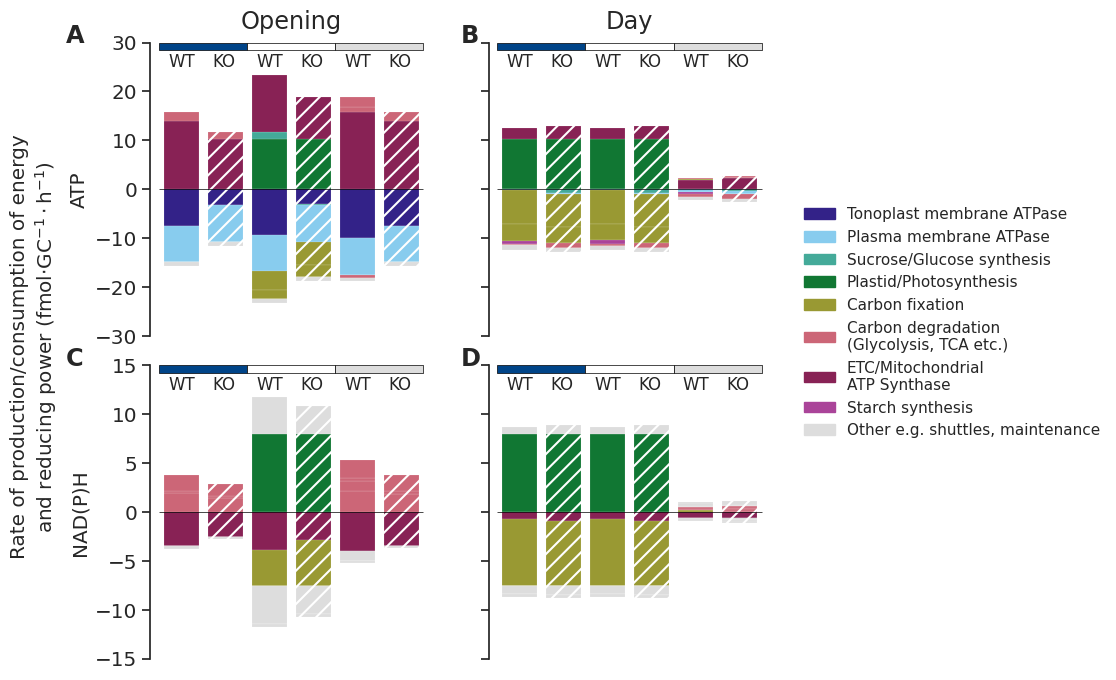

In [109]:
metabolites = ["ATP", "NAD(P)H"]
phases = ["Opening", "Day"]
hatches = {"wt": None, "starchko": "//"}
atpase_labelling = {"unconstrained": "–", "constrained": "+"}

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1)

colour_rectangles_thickness = 4 / (75 * 2)

for y, metabolite in enumerate([atp_budget_df_reordered_nmoles_gc, nadh_nadph_budget_df_reordered_nmoles_gc]):
    for x, phase in enumerate([2, 3]):
        budget_df = metabolite.xs(phase, level="Phase")
        ax = axs[y][x]
   
        if y == 0:
            for x1, x2, colour in zip([-0.5, 1.5, 3.5], [1.5, 3.5, 5.5], ["#004488", "white", "#DDDDDD"]):
                ax.fill_betweenx(
                    [30 - colour_rectangles_thickness * 30 * 2, 30],
                    x1,
                    x2,
                    alpha=1,
                    color=colour,
                    linewidth=0.5,
                    edgecolor="black",
                )
            for i in range(6):
                if i % 2 == 0:
                    ax.text(i-0.3, 30-5, "WT")
                else:
                    ax.text(i-0.3, 30-5, "KO")
        if y == 1:
            for x1, x2, colour in zip([-0.5, 1.5, 3.5], [1.5, 3.5, 5.5], ["#004488", "white", "#DDDDDD"]):
                ax.fill_betweenx(
                    [15 - colour_rectangles_thickness * 15 * 2, 15],
                    x1,
                    x2,
                    alpha=1,
                    color=colour,
                    linewidth=0.5,
                    edgecolor="black",
                )
            for i in range(6):
                if i % 2 == 0:
                    ax.text(i-0.3, 15-5/2, "WT")
                else:
                    ax.text(i-0.3, 15-5/2, "KO")
        for i, scenario in enumerate(budget_df.columns):
            positive_bottom = 0
            negative_top = 0
            scenario_df = budget_df.loc[:, scenario]
            for reaction in scenario_df.index:
                value = scenario_df.loc[reaction]
                if value > 0.00001:
                    ax.bar(
                        i,
                        value,
                        bottom=positive_bottom,
                        color=reaction_colours[reaction][1],
                        linewidth=0.1,
                        hatch=hatches[scenario[2]],
                    )
                    positive_bottom += value
                elif value < 0.00001:
                    ax.bar(
                        i,
                        value,
                        bottom=negative_top,
                        color=reaction_colours[reaction][0],
                        linewidth=0.1,
                        hatch=hatches[scenario[2]],
                    )
                    negative_top += value

        ax.set_xticks([])  # range(len(budget_df.columns)))
        ax.set_xticklabels([])  # [atpase_labelling[scenario[1]] for scenario in budget_df.columns])

        if y == 0:
            ax.set_title(phases[x], pad=10)
        if x == 0:
            ax.set_ylabel(metabolites[y])

        ax.set_xlim(-0.70, 5.7)
        if y == 0:
            ax.set_ylim(-30, 30)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_bounds(-30, 30)
            ax.yaxis.set_major_locator(MultipleLocator(10))
        if y == 1:
            ax.set_ylim(-15, 15)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_bounds(-15, 15)
            ax.yaxis.set_major_locator(MultipleLocator(5))

        ax.hlines(0, -0.5, 5.5, color="black", linewidth=0.5)
        

        
#starch_condition = {"wt": "WT", "starchko": "KO"}[scenario_df.name[2]]
#ax.text(i, -1.5, starch_condition, ha="center", va="center", size="small")

fig.text(
    -0.02,
    0.5,
    r"Rate of production/consumption of energy" "\n" "and reducing power (fmol$\cdot$GC$^{-1}\cdot$h$^{-1}$)",
    rotation=90,
    va="center",
    ha="center",
    size="large",
)

patchList = []
for key in colours_legend:
    data_key = mpatches.Patch(color=colours_legend[key], label=key)
    patchList.append(data_key)

fig.legend(handles=patchList, loc="center left", bbox_to_anchor=(0.925, 0.53))

i = 0
for y in range(2):
    for x in range(2):
        ax = axs[y][x]
        letter = string.ascii_uppercase[i]
        if x == 0:
            ax.text(-0.3, 1, letter, size="x-large", weight="bold", transform=ax.transAxes)
        elif x == 1:
            ax.text(-0.1, 1, letter, size="x-large", weight="bold", transform=ax.transAxes)
        i += 1

fig.savefig(f"../plant_cell_paper/figure_5.svg", bbox_inches="tight")
fig.savefig(f"../plant_cell_paper/figure_5.png", dpi=300, bbox_inches="tight")

In [110]:
budget_df.columns[2]

('white', 'constrained', 'wt')

In [111]:
carbon_rank = gc_carbon_production_consumption_nmoles_gc.sum().rank(ascending=False)

In [112]:
atp_2_rank = abs(atp_budget_df_reordered_nmoles_gc).xs(2, level="Phase").sum().rank(ascending=False)
atp_3_rank = abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase").sum().rank(ascending=False)
atp_rank = (
    (
        abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 0.5
        + abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 11.5
    )
    .sum()
    .rank(ascending=False)
)

In [113]:
nad_2_rank = abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(2, level="Phase").sum().rank(ascending=False)
nad_3_rank = abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase").sum().rank(ascending=False)
nad_rank = (
    (
        abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 0.5
        + abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 11.5
    )
    .sum()
    .rank(ascending=False)
)

In [114]:
pd.concat(
    [carbon_rank, atp_2_rank, atp_3_rank, atp_rank, nad_2_rank, nad_3_rank, nad_rank],
    axis=1,
    keys=["Carbon", "ATP 2", "ATP 3", "ATP Day", "NAD 2", "NAD 3", "NAD Day"],
).sort_values("Carbon")

Carbon  ATP 2  ATP 3  ATP Day  NAD 2  NAD 3  \
Light ATPase      Starch                                                  
white constrained wt           1.0    1.0    3.0      3.0    1.0    3.0   
                  starchko     2.0    3.0    1.0      1.0    2.0    1.0   
blue  constrained wt           3.0    4.0    4.0      4.0    4.0    4.0   
                  starchko     4.0    6.0    2.0      2.0    6.0    2.0   
nops  constrained wt           5.0    2.0    6.0      6.0    3.0    6.0   
                  starchko     6.0    5.0    5.0      5.0    5.0    5.0   

                            NAD Day  
Light ATPase      Starch             
white constrained wt            3.0  
                  starchko      1.0  
blue  constrained wt            4.0  
                  starchko      2.0  
nops  constrained wt            6.0  
                  starchko      5.0

- Starch KO leads to lower carbon consumption and higher ATP and NAD turnover
- Constraining ATPase leads to lower efficiency and higher ATP and NAD turnover
- PS is more complicated because it's both phases, so won't include
    - Removing it vs blue eads to 

## Bits and bobs for paper

In [115]:
blue_constrained_wt_osmolytes = met_df_mm.loc[:, ("blue", "constrained", "wt", "fluxes")].unstack()
os_fraction = (
    (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0])
    / (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).sum()
    * 100
)
os_fraction

Reaction
CIT        -4.589221
Cl         28.453754
FRU        12.722593
GLC        50.267547
K          25.827026
MAL         1.975550
STARCH     -0.009527
SUCROSE   -14.647722
dtype: float64

In [116]:
blue_constrained_wt_osmolytes

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
0.0,0.913845,13.230458,0.659698,0.000000,23.983912,10.563843,0.005126,7.881206
6.0,2.469230,13.949153,0.000000,0.000000,24.702607,8.230766,0.005126,7.881206
6.5,0.000000,29.258693,6.845390,27.046449,38.598836,9.293710,0.000000,0.000000
18.0,0.000000,12.672361,1.318969,0.000000,23.425815,11.934610,0.005126,7.881206
24.0,0.913845,13.230458,0.659698,0.000000,23.983912,10.563843,0.005126,7.881206


In [117]:
os_fraction.loc["Cl"] + os_fraction.loc["K"]

54.28077968179562

In [118]:
(blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).loc["Cl"] + (
    blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]
).loc["K"]

29.20576868235993

In [119]:
solutions_df

Light                                 blue                                  \
ATPase                       unconstrained                                   
Starch                                  wt                        starchko   
Solution                            fluxes minimum   maximum        fluxes   
Reaction               Phase                                                 
EX_X_pi_t_me           1          0.000000     NaN       NaN  0.000000e+00   
                       2          0.000000     NaN       NaN  0.000000e+00   
                       3          0.000000     NaN       NaN  0.000000e+00   
                       4          0.000000     NaN       NaN  0.000000e+00   
EX_X_pi_t_gc           1          0.000000     NaN       NaN  0.000000e+00   
...                                    ...     ...       ...           ...   
Cl_total_pseudolinker  4          0.003642     NaN       NaN  4.838743e-03   
CIT_total_pseudolinker 1          0.000559     0.0  0.010896  0.000000e+00   
                       2          0.000000     0.0  0.011386  5.532588e-08   
                       3          0.000000     NaN       NaN  5.532588e-08   
                       4          0.000280     NaN       NaN  0.000000e+00   

Light                                                                         \
ATPase                                         constrained                     
Starch                                                  wt                     
Solution                     minimum   maximum      fluxes minimum   maximum   
Reaction               Phase                                                   
EX_X_pi_t_me           1         NaN       NaN    0.000000     NaN       NaN   
                       2         NaN       NaN    0.000000     NaN       NaN   
                       3         NaN       NaN    0.000000     NaN       NaN   
                       4         NaN       NaN    0.000000     NaN       NaN   
EX_X_pi_t_gc           1         NaN       NaN    0.000000     NaN       NaN   
...                              ...       ...         ...     ...       ...   
Cl_total_pseudolinker  4         NaN       NaN    0.002916     NaN       NaN   
CIT_total_pseudolinker 1         0.0  0.010896    0.000544     0.0  0.010896   
                       2         0.0  0.011386    0.000000     0.0  0.011386   
                       3         NaN       NaN    0.000000     NaN       NaN   
                       4         NaN       NaN    0.000201     NaN       NaN   

Light                                   ...          nops                    \
ATPase                                  ... unconstrained                     
Starch                        starchko  ...            wt  starchko           
Solution                        fluxes  ...       maximum    fluxes minimum   
Reaction               Phase            ...                                   
EX_X_pi_t_me           1      0.000000  ...           NaN  0.000000     NaN   
                       2      0.000000  ...           NaN  0.000000     NaN   
                       3      0.000000  ...           NaN  0.000000     NaN   
                       4      0.000000  ...           NaN  0.000000     NaN   
EX_X_pi_t_gc           1      0.000000  ...           NaN  0.000000     NaN   
...                                ...  ...           ...       ...     ...   
Cl_total_pseudolinker  4      0.000089  ...           NaN  0.000654     NaN   
CIT_total_pseudolinker 1      0.000408  ...      0.010896  0.000534     0.0   
                       2      0.000000  ...      0.011386  0.000000     0.0   
                       3      0.000000  ...           NaN  0.000534     NaN   
                       4      0.000065  ...           NaN  0.000534     NaN   

Light                                                                 \
ATPase                                 constrained                     
Starch                                          wt           

In [120]:
(
    solutions_df.xs("fluxes", level="Solution", axis=1).loc[("K_ec_gc", 2), :]
    + solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Cl_PROTON_ec_gc", 2), :]
)

Light  ATPase         Starch  
blue   unconstrained  wt          0.023791
                      starchko    0.024396
       constrained    wt          0.013050
                      starchko    0.013050
white  unconstrained  wt          0.024203
                      starchko    0.024209
       constrained    wt          0.013050
                      starchko    0.013050
nops   unconstrained  wt          0.022778
                      starchko    0.022778
       constrained    wt          0.013050
                      starchko    0.013050
dtype: float64

In [121]:
0.013015 / 0.024387 * 100

53.36859802353714

In [122]:
blue_constrained_starcko_osmolytes = met_df_mm.loc[:, ("blue", "constrained", "starchko", "fluxes")].unstack()
os_fraction = (
    (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0])
    / (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).sum()
    * 100
)
os_fraction

Reaction
CIT        -4.589221
Cl         28.453754
FRU        12.722593
GLC        50.267547
K          25.827026
MAL         1.975550
STARCH     -0.009527
SUCROSE   -14.647722
dtype: float64

In [123]:
blue_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,2.46923,13.949153,0.00000,0.000000,24.702607,8.230766,0.005126,7.881206
6.5,0.00000,29.258693,6.84539,27.046449,38.598836,9.293710,0.000000,0.000000


In [124]:
white_constrained_wt_osmolytes = met_df_mm.loc[:, ("white", "constrained", "wt", "fluxes")].unstack()
white_constrained_starcko_osmolytes = met_df_mm.loc[:, ("white", "constrained", "starchko", "fluxes")].unstack()

In [125]:
white_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,0.0,4.731174,0.000000,0.000000,21.206301,0.0,0.005417,6.148247
6.5,0.0,21.252220,7.481205,24.905437,35.562045,0.0,0.000000,0.000000


In [126]:
nops_constrained_wt_osmolytes = met_df_mm.loc[:, ("nops", "constrained", "wt", "fluxes")].unstack()
nops_constrained_starchko_osmolytes = met_df_mm.loc[:, ("nops", "constrained", "starchko", "fluxes")].unstack()

In [127]:
nops_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,2.77789,0.000000,0.000000,0.000000,15.587748,0.000000,0.002556,18.847031
6.5,0.00000,17.142857,16.369993,25.840051,30.681930,3.619194,0.000000,0.000000


In [128]:
nops_constrained_starchko_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,2.465388,0.000000,0.000000,0.000000,13.141954,8.217960,0.0,31.139004
6.5,0.000000,17.142857,27.046449,27.046449,28.557583,9.279252,0.0,0.000000


In [129]:
1-(6.148247/7.881206)

0.21988500237146447

In [130]:
1-(0.005417/0.005126)

-0.05676941084666409

In [131]:
blue_constrained_starcko_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,1.849573,1.121672,0.000000,0.000000,24.082950,6.165238,0.0,31.139003
6.5,0.000000,18.117110,27.046449,27.046449,38.060619,6.961435,0.0,0.000000


In [132]:
white_constrained_starcko_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,0.0,0.658665,0.000000,0.000000,22.233377,0.0,0.0,30.879805
6.5,0.0,17.714955,26.821316,26.821316,36.454133,0.0,0.0,0.225133


In [133]:
27.828905 * 2

55.65781

In [134]:
31.139003/7.881206

3.951045436447163

In [135]:
met_df.loc[:, ("white", "constrained")].xs("fluxes", level="Solution", axis=1).loc[([6.0, 6.5], "STARCH"), :]

/tmp/ipykernel_5249/1419630875.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  met_df.loc[:, ("white", "constrained")].xs("fluxes", level="Solution", axis=1).loc[([6.0, 6.5], "STARCH"), :]


,Starch,wt,starchko
Phase,Reaction,,
6.0,STARCH,0.005417,0.0
6.5,STARCH,0.000000,0.0


In [136]:
(0.005417 * 10**-3 / arabidopsis_supermodel.N_gcs) * 10**15

9.339655172413792

In [137]:
met_df.loc[:, ("blue", "constrained")].xs("fluxes", level="Solution", axis=1).loc[([6.0, 6.5], "STARCH"), :]

/tmp/ipykernel_5249/2596957767.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  met_df.loc[:, ("blue", "constrained")].xs("fluxes", level="Solution", axis=1).loc[([6.0, 6.5], "STARCH"), :]


,Starch,wt,starchko
Phase,Reaction,,
6.0,STARCH,0.005126,0.0
6.5,STARCH,0.000000,0.0


In [138]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_ATPase_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.007930
                      starchko    0.008132
       constrained    wt          0.004350
                      starchko    0.004350
white  unconstrained  wt          0.008068
                      starchko    0.008070
       constrained    wt          0.004350
                      starchko    0.004350
nops   unconstrained  wt          0.008348
                      starchko    0.008348
       constrained    wt          0.004350
                      starchko    0.004350
Name: (PROTON_ATPase_c_gc, 2), dtype: float64

In [139]:
solutions_df

Light                                 blue                                  \
ATPase                       unconstrained                                   
Starch                                  wt                        starchko   
Solution                            fluxes minimum   maximum        fluxes   
Reaction               Phase                                                 
EX_X_pi_t_me           1          0.000000     NaN       NaN  0.000000e+00   
                       2          0.000000     NaN       NaN  0.000000e+00   
                       3          0.000000     NaN       NaN  0.000000e+00   
                       4          0.000000     NaN       NaN  0.000000e+00   
EX_X_pi_t_gc           1          0.000000     NaN       NaN  0.000000e+00   
...                                    ...     ...       ...           ...   
Cl_total_pseudolinker  4          0.003642     NaN       NaN  4.838743e-03   
CIT_total_pseudolinker 1          0.000559     0.0  0.010896  0.000000e+00   
                       2          0.000000     0.0  0.011386  5.532588e-08   
                       3          0.000000     NaN       NaN  5.532588e-08   
                       4          0.000280     NaN       NaN  0.000000e+00   

Light                                                                         \
ATPase                                         constrained                     
Starch                                                  wt                     
Solution                     minimum   maximum      fluxes minimum   maximum   
Reaction               Phase                                                   
EX_X_pi_t_me           1         NaN       NaN    0.000000     NaN       NaN   
                       2         NaN       NaN    0.000000     NaN       NaN   
                       3         NaN       NaN    0.000000     NaN       NaN   
                       4         NaN       NaN    0.000000     NaN       NaN   
EX_X_pi_t_gc           1         NaN       NaN    0.000000     NaN       NaN   
...                              ...       ...         ...     ...       ...   
Cl_total_pseudolinker  4         NaN       NaN    0.002916     NaN       NaN   
CIT_total_pseudolinker 1         0.0  0.010896    0.000544     0.0  0.010896   
                       2         0.0  0.011386    0.000000     0.0  0.011386   
                       3         NaN       NaN    0.000000     NaN       NaN   
                       4         NaN       NaN    0.000201     NaN       NaN   

Light                                   ...          nops                    \
ATPase                                  ... unconstrained                     
Starch                        starchko  ...            wt  starchko           
Solution                        fluxes  ...       maximum    fluxes minimum   
Reaction               Phase            ...                                   
EX_X_pi_t_me           1      0.000000  ...           NaN  0.000000     NaN   
                       2      0.000000  ...           NaN  0.000000     NaN   
                       3      0.000000  ...           NaN  0.000000     NaN   
                       4      0.000000  ...           NaN  0.000000     NaN   
EX_X_pi_t_gc           1      0.000000  ...           NaN  0.000000     NaN   
...                                ...  ...           ...       ...     ...   
Cl_total_pseudolinker  4      0.000089  ...           NaN  0.000654     NaN   
CIT_total_pseudolinker 1      0.000408  ...      0.010896  0.000534     0.0   
                       2      0.000000  ...      0.011386  0.000000     0.0   
                       3      0.000000  ...           NaN  0.000534     NaN   
                       4      0.000065  ...           NaN  0.000534     NaN   

Light                                                                 \
ATPase                                 constrained                     
Starch                                          wt           

In [140]:
pm_proton_pump = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTONATP_rev_vc_gc", 2), :]
for value in pm_proton_pump.values:
    print("{0:.10f}".format(value))

0.0041801723
0.0036862120
0.0043404901
0.0019368158
0.0032286505
0.0032122779
0.0053927508
0.0018125633
0.0052208853
0.0052208730
0.0058439201
0.0043255894


In [141]:
tonoplast_proton_pump = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_PPi_rev_vc_gc", 2), :]
tonoplast_proton_pump

Light  ATPase         Starch  
blue   unconstrained  wt          0.000357
                      starchko    0.000588
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.001561
                      starchko    0.001568
       constrained    wt          0.000000
                      starchko    0.001257
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
Name: (PROTON_PPi_rev_vc_gc, 2), dtype: float64

<Axes: xlabel='Light,ATPase,Starch'>

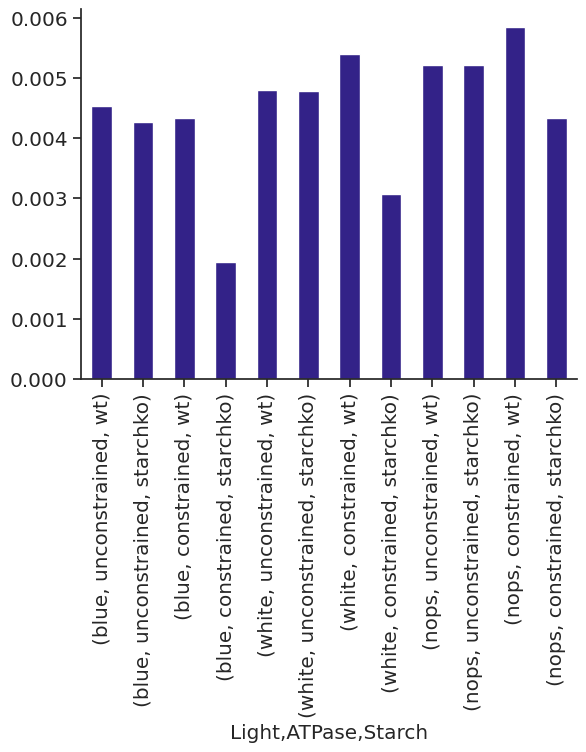

In [142]:
(pm_proton_pump + tonoplast_proton_pump).plot.bar()

In [143]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PHOSGLYPHOS_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000476
                      starchko    0.000784
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
nops   unconstrained  wt         -0.000262
                      starchko   -0.000262
       constrained    wt         -0.000612
                      starchko    0.000000
Name: (PHOSGLYPHOS_RXN_c_gc, 2), dtype: float64

In [144]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("2PGADEHYDRAT_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt         -0.000476
                      starchko   -0.000784
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt         -0.000499
                      starchko   -0.000509
       constrained    wt          0.000000
                      starchko    0.000000
nops   unconstrained  wt          0.000262
                      starchko    0.000262
       constrained    wt          0.000612
                      starchko    0.000000
Name: (2PGADEHYDRAT_RXN_c_gc, 2), dtype: float64

MALATE_DEH_RXN_c_gc## Fraction is ATPase vs PPi for tonoplast

In [145]:
pm_proton_pump / (pm_proton_pump + tonoplast_proton_pump) * 100

Light  ATPase         Starch  
blue   unconstrained  wt           92.127600
                      starchko     86.237285
       constrained    wt          100.000000
                      starchko    100.000000
white  unconstrained  wt           67.407572
                      starchko     67.194799
       constrained    wt          100.000000
                      starchko     59.053306
nops   unconstrained  wt          100.000000
                      starchko    100.000000
       constrained    wt          100.000000
                      starchko    100.000000
dtype: float64

In [146]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 2), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/2746888614.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                       blue                       \
ATPase                             unconstrained          constrained   
Starch                                        wt starchko          wt   
Reaction                     Phase                                      
PHOSGLYPHOS_RXN_p_gc         2               0.0      0.0         0.0   
PHOSPHORIBULOKINASE_RXN_p_gc 2               0.0      0.0         0.0   
Plastidial_ATP_Synthase_p_gc 2               0.0      0.0         0.0   
ATP_ADP_Pi_pc_gc             2               0.0      0.0         0.0   

Light                                             white                  nops  \
ATPase                                      constrained           constrained   
Starch                             starchko          wt  starchko          wt   
Reaction                     Phase                                              
PHOSGLYPHOS_RXN_p_gc         2          0.0    0.002173  0.002742         0.0   
PHOSPHORIBULOKINASE_RXN_p_gc 2          0.0    0.001087  0.001371         0.0   
Plastidial_ATP_Synthase_p_gc 2          0.0    0.001968  0.001968         0.0   
ATP_ADP_Pi_pc_gc             2          0.0    0.002646  0.001792         0.0   

Light                                        
ATPase                                       
Starch                             starchko  
Reaction                     Phase           
PHOSGLYPHOS_RXN_p_gc         2          0.0  
PHOSPHORIBULOKINASE_RXN_p_gc 2          0.0  
Plastidial_ATP_Synthase_p_gc 2          0.0  
ATP_ADP_Pi_pc_gc             2          0.0

In [147]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 3), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/3411159466.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                       blue                        \
ATPase                             unconstrained           constrained   
Starch                                        wt  starchko          wt   
Reaction                     Phase                                       
PHOSGLYPHOS_RXN_p_gc         3          0.004054  0.004049    0.003958   
PHOSPHORIBULOKINASE_RXN_p_gc 3          0.002054  0.002059    0.001991   
Plastidial_ATP_Synthase_p_gc 3          0.001968  0.001968    0.001968   
ATP_ADP_Pi_pc_gc             3         -0.000251 -0.000202   -0.000489   
PEPDEPHOS_RXN_p_gc           3          0.000000  0.000000    0.000000   
GLUC1PADENYLTRANS_RXN_p_gc   3          0.000049  0.000000    0.000446   

Light                                              white            \
ATPase                                       constrained             
Starch                              starchko          wt  starchko   
Reaction                     Phase                                   
PHOSGLYPHOS_RXN_p_gc         3      0.003864    0.003975  0.003881   
PHOSPHORIBULOKINASE_RXN_p_gc 3      0.001941    0.001988  0.001940   
Plastidial_ATP_Synthase_p_gc 3      0.001968    0.001968  0.001968   
ATP_ADP_Pi_pc_gc             3      0.000101   -0.000528  0.000084   
PEPDEPHOS_RXN_p_gc           3      0.000000    0.000000  0.000000   
GLUC1PADENYLTRANS_RXN_p_gc   3      0.000000    0.000471  0.000000   

Light                                     nops           
ATPase                             constrained           
Starch                                      wt starchko  
Reaction                     Phase                       
PHOSGLYPHOS_RXN_p_gc         3       -0.000079      0.0  
PHOSPHORIBULOKINASE_RXN_p_gc 3        0.000000      0.0  
Plastidial_ATP_Synthase_p_gc 3        0.000000      0.0  
ATP_ADP_Pi_pc_gc             3       -0.000064      0.0  
PEPDEPHOS_RXN_p_gc           3        0.000079      0.0  
GLUC1PADENYLTRANS_RXN_p_gc   3        0.000222      0.0

In [148]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_3.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 3), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/3582217826.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                blue                                  \
ATPase                      unconstrained           constrained             
Starch                                 wt  starchko          wt  starchko   
Reaction              Phase                                                 
PROTONATP_rev_vc_gc   3          0.000000  0.000000    0.000000  0.000000   
PEPDEPHOS_RXN_c_gc    3          0.000000  0.000000    0.000000  0.000000   
PROTON_ATPase_c_gc    3          0.000000  0.000000    0.000151  0.000154   
UDPKIN_RXN_c_gc       3          0.000133  0.000154    0.000000  0.000443   
PHOSGLYPHOS_RXN_c_gc  3          0.000000  0.000000    0.000000  0.000000   
FRUCTOKINASE_RXN_c_gc 3          0.000000  0.000000    0.000126  0.000572   
ATP_ADP_Pi_pc_gc      3         -0.000251 -0.000202   -0.000489  0.000101   
ATPase_tx_gc          3          0.000534  0.000534    0.000534  0.000534   
ATP_ADP_mc_gc         3          0.000918  0.000891    0.001300  0.001601   
6PFRUCTPHOS_RXN_c_gc  3          0.000000  0.000000    0.000000  0.000000   

Light                             white                  nops            
ATPase                      constrained           constrained            
Starch                               wt  starchko          wt  starchko  
Reaction              Phase                                              
PROTONATP_rev_vc_gc   3        0.000000  0.000000    0.000000  0.000000  
PEPDEPHOS_RXN_c_gc    3        0.000000  0.000000    0.000000  0.000109  
PROTON_ATPase_c_gc    3        0.000118  0.000142    0.000302  0.000310  
UDPKIN_RXN_c_gc       3        0.000000  0.000445    0.000034  0.000249  
PHOSGLYPHOS_RXN_c_gc  3        0.000000  0.000000    0.000000 -0.000109  
FRUCTOKINASE_RXN_c_gc 3        0.000140  0.000567    0.000335  0.000559  
ATP_ADP_Pi_pc_gc      3       -0.000528  0.000084   -0.000064  0.000000  
ATPase_tx_gc          3        0.000534  0.000534    0.000444  0.000444  
ATP_ADP_mc_gc         3        0.001320  0.001603    0.001179  0.001343  
6PFRUCTPHOS_RXN_c_gc  3        0.000000  0.000000    0.000000  0.000000

In [149]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.NADPH_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 3), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/2111125671.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
6PGLUCONDEHYDROG_RXN_p_gc              3          0.000000  0.000000   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3          0.004054  0.004049   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3          0.004593  0.004593   
NADPHox_p_tx_gc                        3          0.000178  0.000178   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3          0.000361  0.000366   
GLU6PDEHYDROG_RXN_p_gc                 3          0.000000  0.000000   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000  0.000000   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.003958  0.003864   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.004593  0.004593   
NADPHox_p_tx_gc                        3        0.000178  0.000178   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.000457  0.000551   
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000  0.000000   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000  0.000000   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.003975  0.003881   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.004593  0.004593   
NADPHox_p_tx_gc                        3        0.000178  0.000178   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.000440  0.000534   
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000  0.000000   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000011  0.000014  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.000000  0.000000  
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.000000  0.000000  
NADPHox_p_tx_gc                        3        0.000023  0.000029  
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.000000  0.000000  
GLU6PDEHYDROG_RXN_p_gc                 3        0.000011  0.000014

In [150]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.NADH_c_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 2), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/1101100446.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                 blue                                 \
ATPase                       unconstrained           constrained            
Starch                                  wt  starchko          wt starchko   
Reaction               Phase                                                
MALATE_DEH_RXN_c_gc    2          0.000476  0.000784         0.0      0.0   
GAPOXNPHOSPHN_RXN_c_gc 2         -0.000476 -0.000784         0.0      0.0   

Light                              white                 nops           
ATPase                       constrained          constrained           
Starch                                wt starchko          wt starchko  
Reaction               Phase                                            
MALATE_DEH_RXN_c_gc    2             0.0      0.0   -0.000612      0.0  
GAPOXNPHOSPHN_RXN_c_gc 2             0.0      0.0    0.000612      0.0

In [151]:
0.003478 - 0.002659

0.0008190000000000003

In [152]:
0.020457 + 0.010742

0.031198999999999998

In [153]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_ATPase_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.007930
                      starchko    0.008132
       constrained    wt          0.004350
                      starchko    0.004350
white  unconstrained  wt          0.008068
                      starchko    0.008070
       constrained    wt          0.004350
                      starchko    0.004350
nops   unconstrained  wt          0.008348
                      starchko    0.008348
       constrained    wt          0.004350
                      starchko    0.004350
Name: (PROTON_ATPase_c_gc, 2), dtype: float64

In [154]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("MALATE_DEHYDROGENASE_NADPs_RXN_p_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.002010
                      starchko    0.002001
       constrained    wt          0.002242
                      starchko    0.001673
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
Name: (MALATE_DEHYDROGENASE_NADPs_RXN_p_gc, 2), dtype: float64

/tmp/ipykernel_5249/377450841.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1)


Text(0, 0.5, 'Flux (mmoles$\\cdot$m$^{-2}$$\\cdot$h$^{-1}$)')

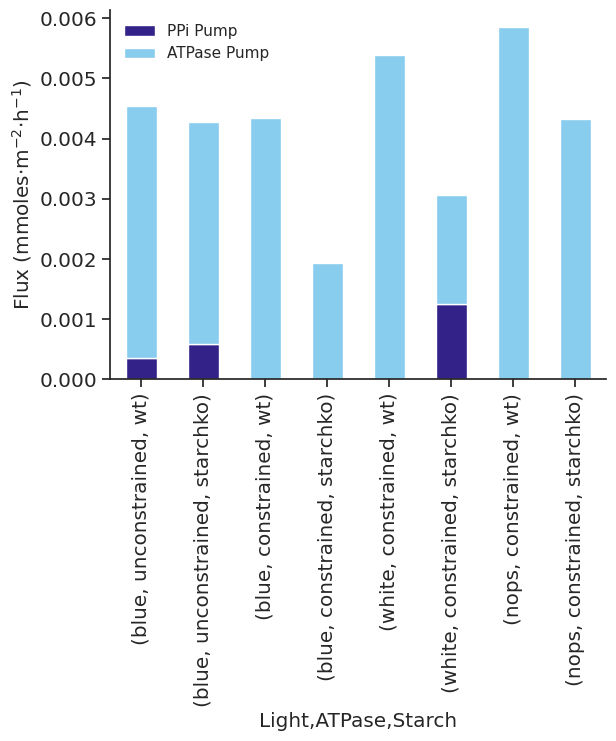

In [155]:
fig, ax = plt.subplots()

tonoplast_proton_transport_df = (
    solutions_df.xs("fluxes", level="Solution", axis=1)
    .loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :]
    .drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)
)
tonoplast_proton_transport_df.index = ["PPi Pump", "ATPase Pump"]
tonoplast_proton_transport_df.T.plot(kind="bar", stacked=True, ax=ax)

ax.set_ylabel("Flux (mmoles$\cdot$m$^{-2}$$\cdot$h$^{-1}$)")

In [156]:
tonoplast_proton_transport_df

Light                blue                                       white  \
ATPase      unconstrained           constrained           constrained   
Starch                 wt  starchko          wt  starchko          wt   
PPi Pump         0.000357  0.000588     0.00000  0.000000    0.000000   
ATPase Pump      0.004180  0.003686     0.00434  0.001937    0.005393   

Light                        nops            
ATPase                constrained            
Starch       starchko          wt  starchko  
PPi Pump     0.001257    0.000000  0.000000  
ATPase Pump  0.001813    0.005844  0.004326

/tmp/ipykernel_5249/1652154496.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :].drop(


<Axes: xlabel='Light,ATPase,Starch'>

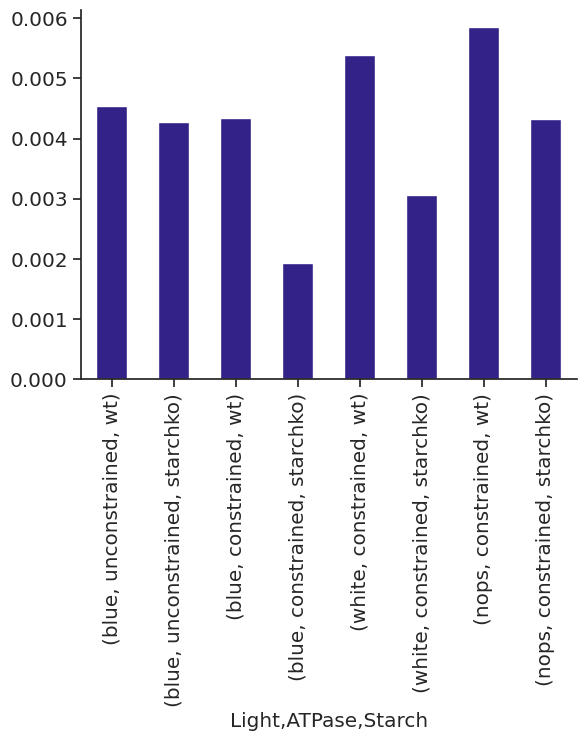

In [157]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :].drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
).sum().plot.bar()

In [158]:
ppi_reactions = [reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.PPI_c_gc_2.reactions]
ppi_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(ppi_reactions, 2), :]
ppi_df = ppi_df.loc[~(abs(ppi_df) < 0.0000000001).all(axis=1)]
ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)

/tmp/ipykernel_5249/4224157383.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)


Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
GLUC1PURIDYLTRANS_RXN_c_gc             2          0.000119  0.000196   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc 2         -0.000238 -0.000392   
PROTON_PPi_rev_vc_gc                   2          0.000357  0.000588   

Light                                                                   white  \
ATPase                                       constrained          constrained   
Starch                                                wt starchko          wt   
Reaction                               Phase                                    
GLUC1PURIDYLTRANS_RXN_c_gc             2             0.0      0.0   -0.000905   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc 2             0.0      0.0   -0.000905   
PROTON_PPi_rev_vc_gc                   2             0.0      0.0    0.000000   

Light                                                         nops           
ATPase                                                 constrained           
Starch                                        starchko          wt starchko  
Reaction                               Phase                                 
GLUC1PURIDYLTRANS_RXN_c_gc             2      0.000114         0.0      0.0  
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc 2     -0.001143         0.0      0.0  
PROTON_PPi_rev_vc_gc                   2      0.001257         0.0      0.0

In [159]:
ppi_reactions = [reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.PPI_p_gc_2.reactions]
ppi_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(ppi_reactions, 2), :]
ppi_df = ppi_df.loc[~(abs(ppi_df) < 0.0000000001).all(axis=1)]
ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)

/tmp/ipykernel_5249/1298146970.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)


Empty DataFrame
Columns: [(blue, unconstrained, wt), (blue, unconstrained, starchko), (blue, constrained, wt), (blue, constrained, starchko), (white, constrained, wt), (white, constrained, starchko), (nops, constrained, wt), (nops, constrained, starchko)]
Index: []

In [160]:
boundary_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.reactions if "_tx" in reaction.id
]
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("NITRATE_a_tx", slice(None)), :]
nitrate_uptake

Light                       blue                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.017802  0.017802    0.017802  0.017802   
             2          0.053405  0.053405    0.053405  0.053405   
             3          0.288754  0.288754    0.288754  0.288754   
             4          0.012081  0.012081    0.012081  0.012081   

Light                      white                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.018684  0.018684    0.018684  0.018684   
             2          0.236743  0.236743    0.236743  0.236742   
             3          0.295351  0.295351    0.295350  0.295350   
             4          0.012419  0.012419    0.012419  0.012419   

Light                       nops                                  
ATPase             unconstrained           constrained            
Starch                        wt  starchko          wt  starchko  
Reaction     Phase                                                
NITRATE_a_tx 1          0.018683  0.018683    0.018683  0.018683  
             2          0.236733  0.236733    0.236732  0.236732  
             3          0.295338  0.295338    0.295337  0.295337  
             4          0.012418  0.012418    0.012418  0.012418

In [161]:
from mmon_gcm.analysing import get_phase_lengths

In [162]:
phase_lengths = get_phase_lengths(arabidopsis_supermodel.fba_model)
phase_lengths

[6.0, 0.5, 11.5, 6.0]

In [163]:
for i, phase_length in zip([1, 2, 3, 4], phase_lengths):
    nitrate_uptake.loc[("NITRATE_a_tx", i), :] = nitrate_uptake.loc[("NITRATE_a_tx", i), :] * phase_length
nitrate_uptake

Light                       blue                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.106810  0.106810    0.106810  0.106810   
             2          0.026703  0.026703    0.026703  0.026703   
             3          3.320676  3.320676    3.320673  3.320670   
             4          0.072484  0.072484    0.072484  0.072484   

Light                      white                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.112106  0.112106    0.112106  0.112106   
             2          0.118371  0.118371    0.118371  0.118371   
             3          3.396533  3.396533    3.396529  3.396526   
             4          0.074511  0.074511    0.074511  0.074511   

Light                       nops                                  
ATPase             unconstrained           constrained            
Starch                        wt  starchko          wt  starchko  
Reaction     Phase                                                
NITRATE_a_tx 1          0.112101  0.112101    0.112101  0.112101  
             2          0.118366  0.118366    0.118366  0.118366  
             3          3.396386  3.396386    3.396377  3.396376  
             4          0.074508  0.074508    0.074508  0.074508

In [164]:
nitrate_uptake_day = nitrate_uptake.loc[(slice(None), [2, 3]), :].sum()
nitrate_uptake_night = nitrate_uptake.loc[(slice(None), [1, 4]), :].sum()

In [165]:
nitrate_uptake_day

Light  ATPase         Starch  
blue   unconstrained  wt          3.347379
                      starchko    3.347379
       constrained    wt          3.347375
                      starchko    3.347373
white  unconstrained  wt          3.514904
                      starchko    3.514904
       constrained    wt          3.514900
                      starchko    3.514897
nops   unconstrained  wt          3.514752
                      starchko    3.514752
       constrained    wt          3.514743
                      starchko    3.514742
dtype: float64

In [166]:
nitrate_uptake_night

Light  ATPase         Starch  
blue   unconstrained  wt          0.179294
                      starchko    0.179294
       constrained    wt          0.179294
                      starchko    0.179294
white  unconstrained  wt          0.186617
                      starchko    0.186617
       constrained    wt          0.186617
                      starchko    0.186617
nops   unconstrained  wt          0.186609
                      starchko    0.186609
       constrained    wt          0.186609
                      starchko    0.186608
dtype: float64

In [167]:
nitrate_uptake_day / nitrate_uptake_night

Light  ATPase         Starch  
blue   unconstrained  wt          18.669741
                      starchko    18.669741
       constrained    wt          18.669741
                      starchko    18.669741
white  unconstrained  wt          18.834845
                      starchko    18.834845
       constrained    wt          18.834845
                      starchko    18.834845
nops   unconstrained  wt          18.834845
                      starchko    18.834845
       constrained    wt          18.834845
                      starchko    18.834845
dtype: float64

In [168]:
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("NITRATE_a_Linker", slice(None)), :]
nitrate_uptake

Light                           blue                                \
ATPase                 unconstrained          constrained            
Starch                            wt starchko          wt starchko   
Reaction         Phase                                               
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0   
                 2               0.0      0.0         0.0      0.0   
                 3               0.0      0.0         0.0      0.0   
                 4               0.0      0.0         0.0      0.0   

Light                          white                                \
ATPase                 unconstrained          constrained            
Starch                            wt starchko          wt starchko   
Reaction         Phase                                               
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0   
                 2               0.0      0.0         0.0      0.0   
                 3               0.0      0.0         0.0      0.0   
                 4               0.0      0.0         0.0      0.0   

Light                           nops                                
ATPase                 unconstrained          constrained           
Starch                            wt starchko          wt starchko  
Reaction         Phase                                              
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0  
                 2               0.0      0.0         0.0      0.0  
                 3               0.0      0.0         0.0      0.0  
                 4               0.0      0.0         0.0      0.0

In [169]:
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("NITRATE_ae_me", slice(None)), :]
nitrate_uptake

Light                        blue                                  \
ATPase              unconstrained           constrained             
Starch                         wt  starchko          wt  starchko   
Reaction      Phase                                                 
NITRATE_ae_me 1          0.017802  0.017802    0.017802  0.017802   
              2          0.053405  0.053405    0.053405  0.053405   
              3          0.288754  0.288754    0.288754  0.288754   
              4          0.012081  0.012081    0.012081  0.012081   

Light                       white                                  \
ATPase              unconstrained           constrained             
Starch                         wt  starchko          wt  starchko   
Reaction      Phase                                                 
NITRATE_ae_me 1          0.018684  0.018684    0.018684  0.018684   
              2          0.236743  0.236743    0.236743  0.236742   
              3          0.295351  0.295351    0.295350  0.295350   
              4          0.012419  0.012419    0.012419  0.012419   

Light                        nops                                  
ATPase              unconstrained           constrained            
Starch                         wt  starchko          wt  starchko  
Reaction      Phase                                                
NITRATE_ae_me 1          0.018683  0.018683    0.018683  0.018683  
              2          0.236733  0.236733    0.236732  0.236732  
              3          0.295338  0.295338    0.295337  0.295337  
              4          0.012418  0.012418    0.012418  0.012418

In [170]:
arabidopsis_supermodel.fba_model.metabolites.NITRATE_e_gc_2

Metabolite identifier,NITRATE_e_gc_2
Name,NITRATE_gc_2
Memory address,0x75ed024cd1c0
Formula,N1O3
Compartment,e
In 2 reaction(s),"NITRATE_ae_gc_2, Nitrate_ec_gc_2"


In [171]:
filtered_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.NADH_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(filtered_reactions, 2), :]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/2808846299.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(


Light                                 blue                                 \
ATPase                       unconstrained           constrained            
Starch                                  wt  starchko          wt starchko   
Reaction               Phase                                                
MALATE_DEH_RXN_c_gc    2          0.000476  0.000784         0.0      0.0   
GAPOXNPHOSPHN_RXN_c_gc 2         -0.000476 -0.000784         0.0      0.0   

Light                              white                 nops           
ATPase                       constrained          constrained           
Starch                                wt starchko          wt starchko  
Reaction               Phase                                            
MALATE_DEH_RXN_c_gc    2             0.0      0.0   -0.000612      0.0  
GAPOXNPHOSPHN_RXN_c_gc 2             0.0      0.0    0.000612      0.0

In [172]:
filtered_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(filtered_reactions, 2), :]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_5249/3469620016.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(


Light                                 blue                                  \
ATPase                       unconstrained           constrained             
Starch                                  wt  starchko          wt  starchko   
Reaction               Phase                                                 
PEPDEPHOS_RXN_c_gc     2          0.000090  0.000665    0.000000  0.000000   
PROTONATP_rev_vc_gc    2          0.004180  0.003686    0.004340  0.001937   
PROTON_ATPase_c_gc     2          0.007930  0.008132    0.004350  0.004350   
UDPKIN_RXN_c_gc        2          0.000119  0.000196    0.000000  0.000000   
PHOSGLYPHOS_RXN_c_gc   2          0.000476  0.000784    0.000000  0.000000   
ATP_ADP_Pi_pc_gc       2          0.000000  0.000000    0.000000  0.000000   
ATPase_tx_gc           2          0.000444  0.000444    0.000444  0.000444   
ATP_ADP_mc_gc          2          0.013626  0.014027    0.009134  0.006731   
6PFRUCTPHOS_RXN_c_gc   2          0.000000  0.000000    0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc 2          0.000566  0.001449    0.000000  0.000000   

Light                              white                  nops            
ATPase                       constrained           constrained            
Starch                                wt  starchko          wt  starchko  
Reaction               Phase                                              
PEPDEPHOS_RXN_c_gc     2        0.000000  0.000000    0.000000  0.000000  
PROTONATP_rev_vc_gc    2        0.005393  0.001813    0.005844  0.004326  
PROTON_ATPase_c_gc     2        0.004350  0.004350    0.004350  0.004350  
UDPKIN_RXN_c_gc        2       -0.000905  0.000114    0.000000  0.000000  
PHOSGLYPHOS_RXN_c_gc   2        0.000000  0.000000   -0.000612  0.000000  
ATP_ADP_Pi_pc_gc       2        0.002646  0.001792    0.000000  0.000000  
ATPase_tx_gc           2        0.000534  0.000534    0.000444  0.000444  
ATP_ADP_mc_gc          2        0.006726  0.005019    0.010332  0.009119  
6PFRUCTPHOS_RXN_c_gc   2        0.000000  0.000000    0.000306  0.000000  
PEPCARBOXYKIN_RXN_c_gc 2        0.000000  0.000000    0.000000  0.000000

In [173]:
filtered_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(filtered_reactions, 2), :]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).loc[:, ("white", "constrained", "wt")]

Reaction                Phase
PEPDEPHOS_RXN_c_gc      2        0.000000
PROTONATP_rev_vc_gc     2        0.005393
PROTON_ATPase_c_gc      2        0.004350
UDPKIN_RXN_c_gc         2       -0.000905
PHOSGLYPHOS_RXN_c_gc    2        0.000000
ATP_ADP_Pi_pc_gc        2        0.002646
ATPase_tx_gc            2        0.000534
ATP_ADP_mc_gc           2        0.006726
6PFRUCTPHOS_RXN_c_gc    2        0.000000
PEPCARBOXYKIN_RXN_c_gc  2        0.000000
Name: (white, constrained, wt), dtype: float64

In [174]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(
    [("white", "unconstrained"), ("nops", "unconstrained")]
)

/tmp/ipykernel_5249/42660494.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(


Light  ATPase         Starch  
blue   unconstrained  wt          0.000566
                      starchko    0.001449
       constrained    wt          0.000000
                      starchko    0.000000
white  constrained    wt          0.000000
                      starchko    0.000000
nops   constrained    wt          0.000000
                      starchko    0.000000
Name: (PEPCARBOXYKIN_RXN_c_gc, 2), dtype: float64

In [175]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(
    [("white", "unconstrained"), ("nops", "unconstrained")]
)

/tmp/ipykernel_5249/42660494.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(


Light  ATPase         Starch  
blue   unconstrained  wt          0.000566
                      starchko    0.001449
       constrained    wt          0.000000
                      starchko    0.000000
white  constrained    wt          0.000000
                      starchko    0.000000
nops   constrained    wt          0.000000
                      starchko    0.000000
Name: (PEPCARBOXYKIN_RXN_c_gc, 2), dtype: float64

In [176]:
phloem_outputs = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Phloem_tx_overall", np.nan), :]

In [177]:
phloem_outputs

Light  ATPase         Starch  
blue   unconstrained  wt          14.258841
                      starchko    14.258841
       constrained    wt          14.258825
                      starchko    14.258816
white  unconstrained  wt          14.965776
                      starchko    14.965776
       constrained    wt          14.965758
                      starchko    14.965748
nops   unconstrained  wt          14.965131
                      starchko    14.965131
       constrained    wt          14.965090
                      starchko    14.965084
Name: (Phloem_tx_overall, nan), dtype: float64

In [178]:
phloem_outputs_dict = {}
for name, value in phloem_outputs.items():
    phloem_outputs_dict[name] = (phloem_outputs / value * 100).round(3)

In [179]:
phloem_outputs_comparison_table = pd.DataFrame.from_dict(phloem_outputs_dict)
phloem_outputs_comparison_table.to_csv("../outputs/efficiency_comparisons/phloem_outputs_compare.csv")
phloem_outputs_comparison_table

blue                                \
                             unconstrained          constrained            
                                        wt starchko          wt starchko   
Light ATPase        Starch                                                 
blue  unconstrained wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
      constrained   wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
white unconstrained wt             104.958  104.958     104.958  104.958   
                    starchko       104.958  104.958     104.958  104.958   
      constrained   wt             104.958  104.958     104.958  104.958   
                    starchko       104.958  104.958     104.958  104.958   
nops  unconstrained wt             104.953  104.953     104.953  104.954   
                    starchko       104.953  104.953     104.953  104.954   
      constrained   wt             104.953  104.953     104.953  104.953   
                    starchko       104.953  104.953     104.953  104.953   

                                     white                                \
                             unconstrained          constrained            
                                        wt starchko          wt starchko   
Light ATPase        Starch                                                 
blue  unconstrained wt              95.276   95.276      95.276   95.277   
                    starchko        95.276   95.276      95.276   95.276   
      constrained   wt              95.276   95.276      95.276   95.276   
                    starchko        95.276   95.276      95.276   95.276   
white unconstrained wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
      constrained   wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
nops  unconstrained wt              99.996   99.996      99.996   99.996   
                    starchko        99.996   99.996      99.996   99.996   
      constrained   wt              99.995   99.995      99.996   99.996   
                    starchko        99.995   99.995      99.995   99.996   

                                      nops                                
                             unconstrained          constrained           
                                        wt starchko          wt starchko  
Light ATPase        Starch                                                
blue  unconstrained wt              95.280   95.280      95.281   95.281  
                    starchko        95.280   95.280      95.281   95.281  
      constrained   wt              95.280   95.280      95.281   95.281  
                    starchko        95.280   95.280      95.281   95.281  
white unconstrained wt             100.004  100.004     100.005  100.005  
                    starchko       100.004  100.004     100.005  100.005  
      constrained   wt             100.004  100.004     100.004  100.005  
                    starchko       100.004  100.004     100.004  100.004  
nops  unconstrained wt             100.000  100.000     100.000  100.000  
                    starchko       100.000  100.000     100.000  100.000  
      constrained   wt             100.000  100.000     100.000  100.000  
                    starchko       100.000  100.000     100.000  100.000

In [180]:
100 - 99.980

0.01999999999999602

In [181]:
phloem_outputs_blue = phloem_outputs.loc["blue"]
phloem_outputs_blue / phloem_outputs_blue.iloc[0] * 100

ATPase         Starch  
unconstrained  wt          100.000000
               starchko     99.999999
constrained    wt           99.999888
               starchko     99.999825
Name: (Phloem_tx_overall, nan), dtype: float64

In [182]:
phloem_outputs_white = phloem_outputs.drop("blue")
phloem_outputs_white = phloem_outputs_white / phloem_outputs_white.iloc[0] * 100
phloem_outputs_white

/tmp/ipykernel_5249/3118140255.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  phloem_outputs_white = phloem_outputs.drop("blue")


Light  ATPase         Starch  
white  unconstrained  wt          100.000000
                      starchko    100.000000
       constrained    wt           99.999883
                      starchko     99.999814
nops   unconstrained  wt           99.995690
                      starchko     99.995690
       constrained    wt           99.995422
                      starchko     99.995379
Name: (Phloem_tx_overall, nan), dtype: float64

In [183]:
phloem_outputs.drop("blue")

/tmp/ipykernel_5249/4124221444.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  phloem_outputs.drop("blue")


Light  ATPase         Starch  
white  unconstrained  wt          14.965776
                      starchko    14.965776
       constrained    wt          14.965758
                      starchko    14.965748
nops   unconstrained  wt          14.965131
                      starchko    14.965131
       constrained    wt          14.965090
                      starchko    14.965084
Name: (Phloem_tx_overall, nan), dtype: float64

<Axes: xlabel='Light,ATPase,Starch'>

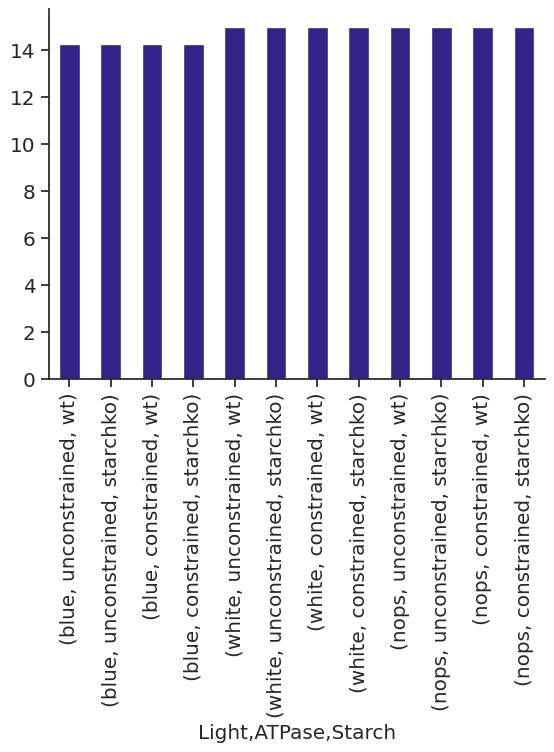

In [184]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Phloem_tx_overall", np.nan), :].plot.bar()

In [185]:
arabidopsis_supermodel.get_prop_gc()

0.0030263085626407423

In [186]:
5.17 * arabidopsis_supermodel.get_prop_gc() * 0.3

0.004693804580655791

In [187]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Cl_cv_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.023145
                      starchko    0.026064
       constrained    wt          0.014849
                      starchko    0.008494
white  unconstrained  wt          0.025841
                      starchko    0.025940
       constrained    wt          0.010786
                      starchko    0.004882
nops   unconstrained  wt          0.016494
                      starchko    0.016494
       constrained    wt          0.008700
                      starchko    0.008700
Name: (Cl_cv_gc, 2), dtype: float64

In [188]:
0.004882/0.010786

0.45262377155572037

In [189]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("K_PROTON_cv_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.008718
                      starchko    0.007961
       constrained    wt          0.008681
                      starchko    0.003874
white  unconstrained  wt          0.008018
                      starchko    0.007993
       constrained    wt          0.010786
                      starchko    0.004882
nops   unconstrained  wt          0.010442
                      starchko    0.010442
       constrained    wt          0.008700
                      starchko    0.002542
Name: (K_PROTON_cv_gc, 2), dtype: float64

In [190]:
0.004882/0.010786

0.45262377155572037

In [191]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("RXN_1461_v_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.003474
                      starchko    0.013726
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.001805
                      starchko    0.013612
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.002988
                      starchko    0.009647
Name: (RXN_1461_v_gc, 2), dtype: float64

In [192]:
0.013612/0.001805

7.541274238227148

In [193]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("K_ec_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.015860
                      starchko    0.016264
       constrained    wt          0.008700
                      starchko    0.008700
white  unconstrained  wt          0.016135
                      starchko    0.016140
       constrained    wt          0.008700
                      starchko    0.008700
nops   unconstrained  wt          0.015185
                      starchko    0.015185
       constrained    wt          0.008700
                      starchko    0.008700
Name: (K_ec_gc, 2), dtype: float64

In [194]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("ISOCITDEH_RXN_c_gc", 3), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000053
                      starchko    0.000062
Name: (ISOCITDEH_RXN_c_gc, 3), dtype: float64

In [195]:
met_df_mm

Light                   blue                                          \
ATPase         unconstrained                                           
Starch                    wt                        starchko           
Solution              fluxes minimum      maximum     fluxes minimum   
Phase Reaction                                                         
0.0   K            24.136132     NaN          NaN  21.955121     NaN   
      Cl           16.525132     NaN          NaN  21.954367     NaN   
      SUCROSE       0.000000     NaN          NaN   0.098507     NaN   
      GLC           0.634252     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.458382     NaN   
      MAL          21.155384     NaN          NaN  24.158591     NaN   
      CIT           1.268503     NaN          NaN   0.000000     NaN   
      STARCH        0.000280     NaN          NaN   0.000000     NaN   
6.0   K            24.136132     0.0   140.262888  22.233565     0.0   
      Cl           16.525132     0.0    89.290671  22.232812     0.0   
      SUCROSE       0.000000     0.0   178.581341   0.000000     0.0   
      GLC           1.268503     0.0   178.581341   0.000000     0.0   
      FRU           0.000000     0.0   178.581341   0.000000     0.0   
      MAL          19.252629     0.0    64.494321  24.158591     0.0   
      CIT           2.537007     0.0    49.435142   0.000000     0.0   
      STARCH        0.000000     0.0  1000.000000   0.000000     0.0   
6.5   K            52.216008     0.0   152.876211  51.358113     0.0   
      Cl           45.605310     0.0   108.221407  51.357459     0.0   
      SUCROSE       0.234614     0.0   216.442814   0.386395     0.0   
      GLC           1.101786     0.0   216.442814   0.000000     0.0   
      FRU           0.000000     0.0   216.442814   0.000000     0.0   
      MAL          17.519298     0.0    65.116825  17.835664     0.0   
      CIT           0.000000     0.0    44.869080   0.000218     0.0   
      STARCH        0.000000     0.0     0.000000   0.000000     0.0   
18.0  K            24.136132     NaN          NaN  21.909670     NaN   
      Cl           16.525132     NaN          NaN  21.908917     NaN   
      SUCROSE       0.000000     NaN          NaN   0.647915     NaN   
      GLC           0.000000     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.000000     NaN   
      MAL          23.058139     NaN          NaN  24.158214     NaN   
      CIT           0.000000     NaN          NaN   0.000251     NaN   
      STARCH        0.000559     NaN          NaN   0.000000     NaN   
24.0  K            24.136132     NaN          NaN  21.955121     NaN   
      Cl           16.525132     NaN          NaN  21.954367     NaN   
      SUCROSE       0.000000     NaN          NaN   0.098507     NaN   
      GLC           0.634252     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.458382     NaN   
      MAL          21.155384     NaN          NaN  24.158591     NaN   
      CIT           1.268503     NaN          NaN   0.000000     NaN   
      STARCH        0.000280     NaN          NaN   0.000000     NaN   

Light                                                                  ...  \
ATPase                     constrained                                 ...   
Starch                              wt                       starchko  ...   
Solution           maximum      fluxes minimum     maximum     fluxes  ...   
Phase Reaction                                                         ...   
0.0   K                NaN   23.983912     NaN         NaN  23.364255  ...   
      Cl               NaN   13.230458     NaN         NaN   0.402977  ...   
      SUCROSE          NaN    7.881206     NaN         NaN  31.139003  ...   
      GLC              NaN    0.000000     NaN         NaN   0.000000  ...   
      FRU              NaN    0.659698     NaN         Na

In [196]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc["Phloem_tx_overall"]

Light           blue                                           white  \
ATPase unconstrained            constrained            unconstrained   
Starch            wt   starchko          wt   starchko            wt   
Phase                                                                  
NaN        14.258841  14.258841   14.258825  14.258816     14.965776   

Light                                             nops                         \
ATPase            constrained            unconstrained            constrained   
Starch   starchko          wt   starchko            wt   starchko          wt   
Phase                                                                           
NaN     14.965776   14.965758  14.965748     14.965131  14.965131    14.96509   

Light              
ATPase             
Starch   starchko  
Phase              
NaN     14.965084

In [197]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("RXN_2141_p_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.005126
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.005417
                      starchko    0.000000
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.002250
                      starchko    0.000000
Name: (RXN_2141_p_gc, 2), dtype: float64

In [198]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("SUCROSE_SYNTHASE_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.001992
                      starchko    0.000000
nops   unconstrained  wt          0.000131
                      starchko    0.000131
       constrained    wt          0.000000
                      starchko    0.000000
Name: (SUCROSE_SYNTHASE_RXN_c_gc, 2), dtype: float64

In [199]:
0.001992/0.005417

0.36773121654052054

In [200]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOX_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000612
                      starchko    0.000000
Name: (PEPCARBOX_RXN_c_gc, 2), dtype: float64

In [201]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTONATP_rev_vc_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.004180
                      starchko    0.003686
       constrained    wt          0.004340
                      starchko    0.001937
white  unconstrained  wt          0.003229
                      starchko    0.003212
       constrained    wt          0.005393
                      starchko    0.001813
nops   unconstrained  wt          0.005221
                      starchko    0.005221
       constrained    wt          0.005844
                      starchko    0.004326
Name: (PROTONATP_rev_vc_gc, 2), dtype: float64

## Analysis on Guard Cell Photon Scan

In [202]:
gc_photon_scan = pd.read_csv("../outputs/scans/gc_photon_scan.csv")

In [203]:
gc_photon_scan.set_index("Unnamed: 0", inplace=True)

In [204]:
glycolysis = gc_photon_scan.loc['3PGAREARR_RXN_c_gc_2']

In [205]:
glycolysis_nmoles_gc = glycolysis.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units]
)

In [206]:
glycolysis_nmoles_gc

0      1.055598
1      1.043212
2      1.030829
3      1.018441
4      1.006055
         ...   
146    0.000000
147    0.000000
148    0.000000
149    0.000000
150    0.000000
Name: 3PGAREARR_RXN_c_gc_2, Length: 151, dtype: float64

In [207]:
(abs(glycolysis) < 1e-7).idxmax() # First PPFD with 0 glycolytic flux

'39'

In [208]:
parameters_df = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)
pm = parameters_df.loc[:, "Value"]

In [209]:
V_l = pm.T_l * pm.A_l  # volume of leaf is area x thickness
V_l = V_l * 10**3  # (Total leaf volume) m3 -> dm3 = 10**3

V_gc = pm.V_gc_ind * pm.N_gcs  # total volume of gc in leaf

# volume of meosphyll is leaf that isn't epidermis or air
V_me = V_l * (1 - pm.L_epidermis) * (1 - pm.L_air)

v_prop_gc = V_gc / V_me  # volume of gc is negligable

In [210]:
me_photon = gc_photon_scan.loc['Photon_tx_me_2']
me_photon_per_vol = me_photon / V_me
gc_photon = gc_photon_scan.loc['Photon_tx_gc_2']
gc_photon_per_vol = gc_photon / V_gc
gc_me_photon_percent_per_vol = gc_photon_per_vol / me_photon_per_vol * 100

In [211]:
# GC photosynthesis as a % of MC photosynthesis per cell volume
gc_me_photon_percent_per_vol.iloc[int((abs(glycolysis) < 1e-7).idxmax())]

0.3247833564048949

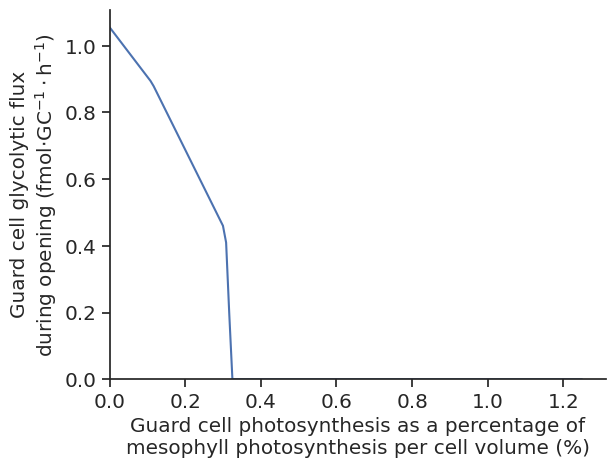

In [213]:
plt.plot(gc_me_photon_percent_per_vol, glycolysis_nmoles_gc, color='b', linestyle='-')

# Add axis labels
plt.xlabel('Guard cell photosynthesis as a percentage of\nmesophyll photosynthesis per cell volume (%)')
plt.ylabel('Guard cell glycolytic flux\nduring opening (fmol$\cdot$GC$^{-1}\cdot$h$^{-1}$)')

# Set x and y axis limits to start from 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.savefig(f"../plant_cell_paper/supplemental_figure_4.svg", bbox_inches="tight")
plt.savefig(f"../plant_cell_paper/supplemental_figure_4.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()